# Deriving dark matter constraints from dwarf galaxies with a data-driven approach

In this notebook, we show how to work with the provided scripts in order to reproduce the analyses presented in [arXiv:1803.05508](https://iopscience.iop.org/article/10.1088/1475-7516/2018/10/029) and [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004).

The general idea of this approach is to improve on the standard Fermi-LAT analysis of dwarf spheroidal galaxies aiming to constrain the parameters of particle dark matter. The main difference arises from the treatment of the expected astrophysical gamma-ray background at the position of a particular dwarf galaxy. While the Fermi-LAT collaboration relies on a conventional assessment of the uncertainty of this background component via a selection of various models, the approach presented here is based on a data-driven technique utilisng the whole-sky data and an optimisation procedure of the expected background levels.

<b> Note: </b> All Fermi-LAT data that comes with this library is the setup used for [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004). In this version of the code, the user is not able to replace these data with a custom data set and to repeat the optimisation routine on such data. We stress here the specifications of the provided LAT data:

- time period: August 4, 2008 (week 9) to June 7, 2018 (week 522),
- event class: SOURCE (P8R2),
- event type: FRONT+BACK,
- energy range: 500 MeV to 500 GeV (24 logarithmically spaced energy bins),
- region of interest: all sky ($0.1^{\circ}\times0.1^{\circ}$ pixels in plate carrée (CAR) projection),
- quality cuts: (DATA_QUAL>0) && (LAT_CONFIG==1),
- zenith angle cut: $>90^{\circ}$.

<b> Outline: </b> In this notebook, we first introduce the handling of the $J$-factor and background profiling routines of this software package. This part of the code can be used to analyse single dwarfs galaxies as well as a selection of dwarfs whose statistical power is stacked to derive a combined upper limit on the relevant dark matter parameters. We show how to manipulate the data input the user is enabled to provide in order to customise the code according to their needs. <br>
In the second part, we use the default parameters of the scripts and input data files to reproduce Fig. 5 of [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004). 

## Setup

  <b>1.  Python modules</b> <br>
  ***
<b>Import all necessary scripts</b> required for the analysis and <b>define the path</b> where the folder with all code is stored.

In [29]:
from LAT_dwarfs import dwarf_profiling as dprof
from LAT_dwarfs import dwarf_setlimits as dlim
from LAT_dwarfs import dwarf_plot as dplot
from LAT_dwarfs import dwarf_voidgen as dvoid
import multiprocessing as mp
import os
import iminuit
print("iminuit:", iminuit.__version__)

##Set the path to the working directory of the folder containing the scripts.
source_path = "./"

iminuit: 1.5.4


<b> 2. Dwarf data table </b> <br>
***
The heart of the analysis is a dwarf spheroidal galaxy summary file, which lists all relevant properties of the dwarfs that may be included in a run of the script. It is called:<br>
<br>
      `default_dwarf_summary_table.dat`<br>
<br>
This table lists the following quantities with some example entries:<br>

| dwarf name | position<br>(2 columns: Galactic longitude/latitude in degree) | $J$-factor<br>(2 columns: $\log_{10}J$ and $\log_{10}\sigma_J$ ) | LAT exposure at dwarf position for each of the 24 energy bins \[cm$^2$ s\] |
| :---: | :---: | :---: | :---: |
| Carina | (260.11, -22.22) | (17.87, 0.07) | 3.32252280e+11 3.61144365e+11 3.84963682e+11 4.14092865e+11 4.31196305e+11 4.40936021e+11 4.43478687e+11 4.40878279e+11 4.33701602e+11 4.36104907e+11 4.37812239e+11 4.37920453e+11 4.37857380e+11 4.36889956e+11 4.42446218e+11 4.48922810e+11 4.49737009e+11 4.48386825e+11 4.47037663e+11 4.45163380e+11 4.44010471e+11 4.43578722e+11 4.43483841e+11 4.40888340e+11 |
| Draco | (86.37, 34.72) | (18.69, 0.05) | 4.02486981e+11 4.37197565e+11 4.66289039e+11 5.01611222e+11 5.22042808e+11 5.33966847e+11 5.37196898e+11 5.33446559e+11 5.25155909e+11 5.28062124e+11 5.30240148e+11 5.30246919e+11 5.30313578e+11 5.29370038e+11 5.35597303e+11 5.43548191e+11 5.44546484e+11 5.42970131e+11 5.41249779e+11 5.39293537e+11 5.38040048e+11 5.37676589e+11 5.37632121e+11 5.34474252e+11 |
| LeoII | (220.17, 67.23) | (17.48, 0.09) | 3.00596565e+11 3.28264033e+11 3.52440798e+11 3.81887576e+11 3.99504645e+11 4.07639952e+11 4.08402258e+11 4.03732760e+11 3.93886598e+11 3.93909777e+11 3.96024602e+11 3.96044668e+11 3.94370130e+11 3.91737383e+11 4.02795175e+11 4.11510480e+11 4.12851105e+11 4.11549393e+11 4.10860748e+11 4.08407909e+11 4.07279034e+11 4.06540708e+11 4.06509656e+11 4.02658200e+11 |

The currently available dwarfs and their properties are taken from the Fermi-LAT collaboration's publication [arXiv:1611.03184](https://iopscience.iop.org/article/10.3847/1538-4357/834/2/110). The user is free to change these values to their likings. <b> Adding dwarfs would require to re-run the background optimisation routine because these positions are not yet part of the provided data tables. Hence, it is currently not possible to do so. The ordering of the dwarfs must not be changed because there are further auxiliary files that follow the same ordering but are not supposed to be touched. </b>

<b> 3. User-defined DM spectrum files </b> <br>
***
By default, the analysis uses the WIMP dark matter differential gamma-ray spectra discussed in the "PPPC 4 DM ID - A Poor Particle Physicist Cookbook for Dark Matter Indirect Detection" [arXiv:1012.4515](https://iopscience.iop.org/article/10.1088/1475-7516/2011/03/051), which come alongside the code with either electroweak corrections (`AtProduction_gammas.dat`) or without them (`AtProductionNoEW_gammas.dat`). Currently, three different spectra may be accessed: `["bb", "WW", "tautau"]`. The choice has to be manually entered in the script `dwarf_profiling.py` by setting the argument `annihil_channel` of the function `integrate_DM_dNdE`. The default is `"bb"`.<br>
<br>
Alternatively, the user has the option to derive constraints on the parameters of any dark matter model as long as they provide a table of the differential gamma-ray spectrum per annihilation event $\mathrm{d}N/\mathrm{d}E$, i.e. the number of gamma rays produced with a particular energy $E$ in a single annihilation event. The expected format of such a spectrum is a simple plain text document with three columns:

| DM mass $m_{\mathrm{DM}}$ | energy E \[GeV\] | $\frac{\mathrm{d}N}{\mathrm{d}E}$ \[GeV$^{-1}$\]|
| :---: | :---: | :---: |
| 50.0 | 0.001 | 0.01 |
| 50.0 | 0.0015 | 0.012 |
| ... | ... | ... |
| 50.0 | 50.0 | 1e-9 |
| 60.0 | 0.001 | 0.0101 |
| ... | ... | ... |

Note that the dark matter mass column repeats in each row the mass value for each entry in the two associated columns. <br>
<b> Note: </b> Setting upper limits at different dark matter masses requires the user to provide the gamma-ray spectrum at the requested dark matter mass. There is no interpolation implemented.

### Running the dSph profiling over $J$-factors and/or background

To initiate the dwarf profiling, we first import the prepared dwarf data table:

In [30]:
dwarf_data = dprof.getdSphs_data_from_table("default_dwarf_summary_table.dat", 29)
## the second argument "29" refers to the number of columns in the dwarf table

To run the main routine of `dwarf_profiling.py` we need to specify secondary specifications of the run:

- Which dwarfs are supposed to be considered?

In [31]:
dwarf_list = ["Draco", "LeoII"] ## This list may contain a single or multiple dwarfs. If there are multiple dwarfs,
                                ## stacking is automatically activated.

- Do you want to include empirical $J$-factors derived and utilised in [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004) that rely on a data-driven shape of the J-factors’ empirical probability distribution? The relevant data may be found in the folder `Jfactors` and it concers the dwarfs: "Draco", "Carina", "Fornax", "LeoI", "LeoII", "Sculptor", "Sextans" and "UrsaMinor". If this option is selected, all dwarfs, for which no empirical $J$-factor results are available, take average $J$-factor value and uncertainty from the dwarf table.

In [33]:
emp_jlist = "Jfactors"
is_empirical = True

- Do you want to use a user-defined dark matter annihilation spectrum? If so, import its path otherwise set it to 'None'.

In [34]:
spectrum = None

- At which dark matter masses do you want to evaluate the profiled likelihood? This has to be specified via a simple plain text file which lists all <b> masses in GeV </b> line by line.

In [35]:
filescan = "scan_DM_mass.dat"

- What is the range of annihilation cross-sections that is used to scan the profiled likelihood function (should be large enough to encompass the cross-section value at which the final limit is being set)?

In [36]:
svmin = 1e-27 ##cm^3/s
svmax = 1e-22 ##cm^3/s

- Specify the input files to generate the optimised background counts! 
You can generate the LAT_data and the LAT_exposure by running the data_preparation notebook.

In [32]:
LAT_data="./misc/CCUBE_P8R2_SOURCE_V6_w9to522_evtype3_nxpix3600_nypix1800_binsz0.1_Elo500_Ehi500000.fits"
LAT_exposure="./misc/expmap_CCUBE_P8R2_SOURCE_V6_w9to522_evtype3_nxpix3600_nypix1800_binsz0.1_Elo500_Ehi500000.fits"
LAT_psf="./misc/lat_alldata_12years_w639_20MeV_1TeV_ULTRACLEANVETO_FRONT+BACK_zmax90_gti_200MeV_500GeV_30Ebins_hpx6_Nside_64_gtpsf_lon_120_lat_40.fits"
psf_source="./gll_psc_v16.fit"
dwarf_table="./default_dwarf_summary_table.dat"

We can now generate the optimized background counts by calling the routines of `dwarf_voidgen.py`. This routine is designed to store the text files in the folder `bkg_data_optimal` which you need to create if run the analysis for the first time. 

In [37]:
### do not forget to run `bkg_data_optimal` if you run the script for the first time
os.system('mkdir ' +'bkg_data_optimal')
bkg_path = source_path + "bkg_data_optimal/"

mkdir: cannot create directory ‘bkg_data_optimal’: File exists


In [38]:
dvoid.perform_background_optimisation(bkg_path,
                LATdata=LAT_data, 
                LATexposure = LAT_exposure,
                dwarf_data_table = dwarf_table,                      
                kind = 'iso',
                source_catalog= psf_source,
)

++++++++++++ generating void centroids ++++++++++++++
optimum bandwidth for lon and lat:  22.27777777777778 8.666666666666668
generating  52524  regions
Nvoids =  52524
1000 -th sample, len(array) =  258
2000 -th sample, len(array) =  541
6000 -th sample, len(array) =  1528
11000 -th sample, len(array) =  2607
14000 -th sample, len(array) =  3171
16000 -th sample, len(array) =  3506
20000 -th sample, len(array) =  4153
21000 -th sample, len(array) =  4282
24000 -th sample, len(array) =  4726
25000 -th sample, len(array) =  4859
26000 -th sample, len(array) =  4991
28000 -th sample, len(array) =  5228
29000 -th sample, len(array) =  5354
31000 -th sample, len(array) =  5577
33000 -th sample, len(array) =  5799
34000 -th sample, len(array) =  5907
35000 -th sample, len(array) =  6020
36000 -th sample, len(array) =  6128
37000 -th sample, len(array) =  6240
38000 -th sample, len(array) =  6349
39000 -th sample, len(array) =  6454
47000 -th sample, len(array) =  7153
49000 -th sample, len(

 [astropy.io.fits.verify]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 58269.450699 from DATE-END'. [astropy.wcs.wcs]


filling region #  0  out of  25
+++++ filling voids positions with counts ++++


 [astropy.io.fits.verify]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 58269.450699 from DATE-END'. [astropy.wcs.wcs]


filling region #  0  out of  7609
filling region #  500  out of  7609
filling region #  1000  out of  7609
filling region #  1500  out of  7609
filling region #  2000  out of  7609
filling region #  2500  out of  7609
filling region #  3000  out of  7609
filling region #  3500  out of  7609
filling region #  4000  out of  7609
filling region #  4500  out of  7609
filling region #  5000  out of  7609
filling region #  5500  out of  7609
filling region #  6000  out of  7609
filling region #  6500  out of  7609
filling region #  7000  out of  7609
filling region #  7500  out of  7609
[0, 1, 2, 3, 4, 6]
++++++ importing counts and coordinates from voids +++++
original len= 7609
new len= 7603
0.14 2.19
+++++++++ this is bin #  0
+++++++++ this is bin #  1
+++++++++ this is bin #  2
+++++++++ this is bin #  3
+++++++++ this is bin #  4
+++++++++ this is bin #  5
sum bckg_est =  [ 98.37555691  36.96712307  33.65552716 339.65996501  42.44225834
 274.51279797  88.78261869 410.07444485 131.49268

True

- The code is parallelised, the user may specify the number of threads to run in parallel.

In [9]:
ncpu = mp.cpu_count() ## maximal number of available threads on your computer

- Do you want to profile only over the $J$-factor uncertainty (`"J"`) or over background and $J$-factors at the same time (`"JB"`)? <br> <b> Besides this choice , the user needs to create (if running the code for the first time) a new folder where the profiling results are stored. The code assumes the existence of such folders so that their name tags have to be either: `profiling_caseJ` or `profiling_caseJB` depending on the user's choice.</b>

In [39]:
case = "J"
### do not forget to run `mkdir profiling_caseJ` if you run the script for the first time
os.system('mkdir ' +'profiling_caseJ') # os.system('mkdir ' + source_path + 'profiling_caseJB')

mkdir: cannot create directory ‘profiling_caseJ’: File exists


256

Now we are ready to run the main routine of the profiling script:

In [40]:
dprof.profiling(dwarf_data, 
                dwarf_list = dwarf_list,
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                case = case,
)

++++ this is dwarf # ++++ this is dwarf #   DracoDraco  sv =    sv = 1e-27 
1e-27++++ this is dwarf # 
 LeoII++++ this is dwarf #    sv = LeoII  1e-27 sv = 
 1e-27
++++ this is dwarf #  Draco  sv =  ++++ this is dwarf # 1e-27
 ++++ this is dwarf #  LeoII Draco sv =   sv =  1e-27
++++ this is dwarf #  LeoII  sv =  1e-27
 1e-27
++++ this is dwarf # ++++ this is dwarf #   DracoDraco   sv =  sv =   1.1233240329780312e-271.1233240329780312e-27

++++ this is dwarf #  LeoII ++++ this is dwarf # ++++ this is dwarf #  sv =   LeoIIDraco  sv =  1.1233240329780312e-27 
++++ this is dwarf #  LeoII 1.1233240329780312e-27 sv =  
1.1233240329780312e-27  sv =  1.1233240329780312e-27

++++ this is dwarf #  Draco  sv =  1.1233240329780312e-27
++++ this is dwarf #  LeoII  sv =  1.1233240329780312e-27
++++ this is dwarf #  Draco  sv =  1.2618568830660184e-27
++++ this is dwarf #  LeoII  sv =  1.2618568830660184e-27
++++ this is dwarf #  Draco  sv =  1.2618568830660184e-27
++++ this is dwarf #  LeoII  sv = 

++++ this is dwarf #  LeoII  sv =  8.111308307896888e-27
++++ this is dwarf #  Draco  sv =  8.111308307896888e-27
++++ this is dwarf #  LeoII  sv =  8.111308307896888e-27
++++ this is dwarf #  Draco  sv =  7.220809018385456e-27
++++ this is dwarf #  LeoII  sv =  7.220809018385456e-27
++++ this is dwarf #  Draco  sv =  9.111627561154868e-27
++++ this is dwarf #  LeoII  sv =  9.111627561154868e-27
++++ this is dwarf #  Draco  sv =  9.111627561154868e-27
++++ this is dwarf #  LeoII  sv =  9.111627561154868e-27
++++ this is dwarf #  Draco  sv =  9.111627561154868e-27
++++ this is dwarf #  LeoII  sv =  9.111627561154868e-27
++++ this is dwarf #  Draco  sv =  1.0235310218990269e-26
++++ this is dwarf # ++++ this is dwarf #  Draco   sv = LeoII 8.111308307896888e-27
++++ this is dwarf #  LeoII   sv =  sv =   8.111308307896888e-27
1.0235310218990269e-26
++++ this is dwarf #  Draco  sv =  1.0235310218990269e-26
++++ this is dwarf #  LeoII  sv =  1.0235310218990269e-26++++ this is dwarf # 
 Draco

++++ this is dwarf #  LeoII  sv =  7.564633275546291e-25
++++ this is dwarf #  Draco  sv =  3.764935806792456e-25
++++ this is dwarf #  LeoII  sv =  3.764935806792456e-25
++++ this is dwarf #  Draco  sv =  3.764935806792456e-25
++++ this is dwarf #  LeoII  sv =  3.764935806792456e-25
++++ this is dwarf #  Draco  sv =  5.994842503189421e-25
++++ this is dwarf #  LeoII  sv =  5.994842503189421e-25
++++ this is dwarf #  Draco  sv =  8.497534359086404e-25
++++ this is dwarf #  LeoII  sv =  8.497534359086404e-25
++++ this is dwarf #  Draco  sv =  4.229242874389499e-25
++++ this is dwarf #  LeoII  sv =  4.229242874389499e-25
++++ this is dwarf #  Draco  sv =  6.734150657750801e-25
++++ this is dwarf #  LeoII  sv =  6.734150657750801e-25
++++ this is dwarf #  Draco  sv =  4.229242874389499e-25
++++ this is dwarf #  LeoII  sv =  4.229242874389499e-25
++++ this is dwarf #  Draco  sv = 9.545484566618328e-25 ++++ this is dwarf # 
 ++++ this is dwarf # Draco  LeoII  sv =  9.545484566618328e-25
 sv

++++ this is dwarf #  LeoII  sv =  1.747528400007683e-23
++++ this is dwarf #  Draco  sv =  1.9630406500402764e-23
++++ this is dwarf #  LeoII  sv =  1.9630406500402764e-23
++++ this is dwarf #  Draco  sv =  5.590810182512223e-23
++++ this is dwarf #  LeoII  sv =  5.590810182512223e-23
++++ this is dwarf #  Draco  sv =  4.9770235643320934e-23
++++ this is dwarf #  LeoII  sv =  4.9770235643320934e-23
++++ this is dwarf #  Draco  sv =  1.9630406500402764e-23
++++ this is dwarf #  LeoII  sv =  1.9630406500402764e-23
++++ this is dwarf #  Draco  sv =  2.2051307399030412e-23
++++ this is dwarf #  LeoII  sv =  2.2051307399030412e-23
++++ this is dwarf #  Draco  sv =  6.280291441834273e-23
++++ this is dwarf #  LeoII  sv =  6.280291441834273e-23
++++ this is dwarf #  Draco  sv =  5.590810182512223e-23
++++ this is dwarf #  LeoII  sv =  5.590810182512223e-23
++++ this is dwarf #  Draco  sv =  2.2051307399030412e-23
++++ this is dwarf #  LeoII  sv =  2.2051307399030412e-23
++++ this is dwarf # 

++++ this is dwarf #  Draco  sv =  1.450828778495943e-26
++++ this is dwarf #  LeoII  sv =  1.450828778495943e-26
++++ this is dwarf #  Draco  sv =  1.2915496650148827e-26
++++ this is dwarf #  LeoII  sv =  1.2915496650148827e-26
++++ this is dwarf #  Draco  sv =  2.9150530628251697e-26
++++ this is dwarf #  LeoII  sv =  2.9150530628251697e-26
++++ this is dwarf #  Draco  sv =  2.310129700083158e-26
++++ this is dwarf #  LeoII  sv =  2.310129700083158e-26
++++ this is dwarf #  Draco  sv =  1.62975083462064e-26
++++ this is dwarf #  LeoII  sv =  1.62975083462064e-26
++++ this is dwarf #  Draco  sv =  1.450828778495943e-26
++++ this is dwarf #  LeoII  sv =  1.450828778495943e-26
++++ this is dwarf #  Draco  sv =  2.5950242113997423e-26
++++ this is dwarf #  LeoII  sv =  2.5950242113997423e-26
++++ this is dwarf #  Draco  sv =  3.2745491628777315e-26
++++ this is dwarf #  LeoII  sv =  3.2745491628777315e-26
++++ this is dwarf #  Draco  sv =  1.8307382802953696e-26
++++ this is dwarf #  Le

++++ this is dwarf #  Draco  sv =  5.994842503189421e-25
++++ this is dwarf #  LeoII  sv =  5.994842503189421e-25
++++ this is dwarf #  Draco  sv =  1.3530477745798076e-24
++++ this is dwarf #  LeoII  sv =  ++++ this is dwarf # 1.3530477745798076e-24
 Draco  sv =  7.564633275546291e-25
++++ this is dwarf #  LeoII  sv =  7.564633275546291e-25
++++ this is dwarf #  Draco  sv =  3.0538555088334125e-24
++++ this is dwarf #  LeoII  sv =  3.0538555088334125e-24
++++ this is dwarf # ++++ this is dwarf #   DracoDraco   sv =  sv =  3.430469286314926e-24 
++++ this is dwarf # 1.519911082952927e-24 LeoII  sv =  3.430469286314926e-24

++++ this is dwarf #  LeoII  sv =  1.519911082952927e-24
++++ this is dwarf #  Draco  sv =  6.734150657750801e-25
++++ this is dwarf #  LeoII  sv =  6.734150657750801e-25++++ this is dwarf # 
 Draco  sv =  8.497534359086404e-25
++++ this is dwarf #  LeoII  sv =  8.497534359086404e-25
++++ this is dwarf #  Draco  sv =  3.8535285937105195e-24
++++ this is dwarf #  LeoI

++++ this is dwarf #  LeoII  sv =  ++++ this is dwarf #  Draco  sv =  1.2618568830660184e-271e-22
++++ this is dwarf #  LeoII  sv = 
 1.2618568830660184e-27
++++ this is dwarf #  Draco  sv =  4.430621457583887e-23
++++ this is dwarf #  LeoII  sv =  4.430621457583887e-23
++++ this is dwarf #  Draco  sv =  4.430621457583887e-23
++++ this is dwarf #  LeoII  sv =  4.430621457583887e-23
++++ this is dwarf #  Draco  sv =  1.4174741629268077e-27
++++ this is dwarf #  LeoII  sv =  1.4174741629268077e-27
++++ this is dwarf #  Draco  sv =  4.9770235643320934e-23
++++ this is dwarf #  LeoII  sv =  4.9770235643320934e-23
++++ this is dwarf #  Draco  sv =  4.9770235643320934e-23
++++ this is dwarf #  LeoII  sv =  4.9770235643320934e-23
++++ this is dwarf #  Draco  sv =  1e-27
++++ this is dwarf #  LeoII  sv =  1e-27
++++ this is dwarf #  ++++ this is dwarf # Draco   sv = Draco 1.5922827933410874e-27 
 sv =  5.590810182512223e-23
++++ this is dwarf # ++++ this is dwarf #   LeoII  sv = LeoII  1.59228

++++ this is dwarf #  Draco  sv =  2.9150530628251697e-26
++++ this is dwarf #  LeoII  sv =  2.9150530628251697e-26
++++ this is dwarf #  Draco  sv =  7.390722033525776e-26
++++ this is dwarf #  LeoII  sv =  7.390722033525776e-26
++++ this is dwarf #  Draco  sv =  5.857020818056673e-26
++++ this is dwarf #  LeoII  sv =  5.857020818056673e-26
++++ this is dwarf #  Draco  sv =  2.5950242113997423e-26
++++ this is dwarf #  LeoII  sv =  2.5950242113997423e-26
++++ this is dwarf #  Draco  sv =  8.30217568131977e-26
++++ this is dwarf # ++++ this is dwarf #  Draco  LeoII sv =   3.2745491628777315e-26 sv = 
 ++++ this is dwarf # 8.30217568131977e-26 
LeoII  sv =  3.2745491628777315e-26
++++ this is dwarf #  Draco  sv =  6.579332246575655e-26
++++ this is dwarf #  LeoII  sv =  6.579332246575655e-26
++++ this is dwarf #  Draco  sv =  2.9150530628251697e-26
++++ this is dwarf #  LeoII  sv =  2.9150530628251697e-26
++++ this is dwarf #  Draco  sv =  9.32603346883218e-26
++++ this is dwarf #  LeoI

++++ this is dwarf #  Draco  sv =  1.2045035402587788e-24
++++ this is dwarf #  LeoII  sv =  1.2045035402587788e-24
++++ this is dwarf #  Draco  sv =  1.7073526474706888e-24
++++ this is dwarf #  LeoII  sv =  1.7073526474706888e-24
++++ this is dwarf #  Draco  sv =  3.8535285937105195e-24++++ this is dwarf # 
++++ this is dwarf #  Draco LeoII  sv =   sv =   6.135907273413189e-243.8535285937105195e-24
++++ this is dwarf #  LeoII
  sv =  6.135907273413189e-24
++++ this is dwarf #  Draco  sv =  ++++ this is dwarf #  Draco 6.892612104349681e-24 sv = 
++++ this is dwarf #   1.9179102616724927e-24LeoII
++++ this is dwarf #    sv =  6.892612104349681e-24LeoII
  sv =  1.9179102616724927e-24
++++ this is dwarf #  Draco  sv =  4.3287612810830616e-24
++++ this is dwarf #  LeoII  sv =  4.3287612810830616e-24
++++ this is dwarf #  Draco  sv =  1.3530477745798076e-24
++++ this is dwarf #  LeoII  sv =  1.3530477745798076e-24
++++ this is dwarf #  Draco  sv =  2.1544346900318778e-24
++++ this is dwarf

++++ this is dwarf #  Draco  sv =  3.1992671377973845e-27
++++ this is dwarf #  LeoII  sv =  3.1992671377973845e-27
++++ this is dwarf #  Draco  sv =  7.054802310718631e-23
++++ this is dwarf #  LeoII  sv =  7.054802310718631e-23
++++ this is dwarf #  Draco  sv =  2.257019719633917e-27
++++ this is dwarf #  LeoII  sv =  2.257019719633917e-27
++++ this is dwarf #  Draco  sv =  1.2618568830660184e-27
++++ this is dwarf #  LeoII  sv =  1.2618568830660184e-27
++++ this is dwarf #  Draco  sv =  7.924828983539185e-23
++++ this is dwarf #  LeoII  sv =  7.924828983539185e-23
++++ this is dwarf #  Draco  sv =  2.5353644939701167e-27
++++ this is dwarf #  LeoII  sv =  2.5353644939701167e-27
++++ this is dwarf #  Draco  sv =  3.593813663804641e-27
++++ this is dwarf #  LeoII  sv =  3.593813663804641e-27
++++ this is dwarf #  Draco  sv =  8.902150854450356e-23
++++ this is dwarf #  LeoII  sv =  8.902150854450356e-23
++++ this is dwarf #  Draco  sv =  1.4174741629268077e-27
++++ this is dwarf #  Le

++++ this is dwarf #  Draco  sv =  2.104904144512013e-25
++++ this is dwarf #  LeoII  sv =  2.104904144512013e-25
++++ this is dwarf #  Draco  sv =  1.4849682622544697e-25
++++ this is dwarf #  LeoII  sv =  1.4849682622544697e-25
++++ this is dwarf #  Draco  sv =  7.390722033525776e-26
++++ this is dwarf #  LeoII  sv =  7.390722033525776e-26
++++ this is dwarf #  Draco  sv =  4.1320124001153346e-26
++++ this is dwarf #  LeoII  sv =  4.1320124001153346e-26
++++ this is dwarf #  Draco  sv =  2.3644894126454073e-25
++++ this is dwarf #  LeoII  sv =  2.3644894126454073e-25
++++ this is dwarf #  Draco  sv =  8.30217568131977e-26
++++ this is dwarf #  LeoII  sv =  8.30217568131977e-26
++++ this is dwarf #  Draco  sv =  1.6681005372000557e-25
++++ this is dwarf #  LeoII  sv =  1.6681005372000557e-25
++++ this is dwarf #  Draco  sv =  4.641588833612792e-26
++++ this is dwarf #  LeoII  sv =  4.641588833612792e-26
++++ this is dwarf #  Draco  sv =  2.656087782946695e-25
++++ this is dwarf #  Leo

++++ this is dwarf #  Draco  sv =  1.9630406500402764e-23
++++ this is dwarf #  LeoII  sv =  1.9630406500402764e-23
++++ this is dwarf #  Draco  sv =  2.1544346900318778e-24
++++ this is dwarf #  LeoII  sv =  2.1544346900318778e-24
++++ this is dwarf #  Draco  sv =  3.430469286314926e-24
++++ this is dwarf #  LeoII  sv =  3.430469286314926e-24
++++ this is dwarf #  Draco  sv =  9.770099572992247e-24
++++ this is dwarf #  LeoII  sv =  9.770099572992247e-24
++++ this is dwarf #  Draco  sv =  2.2051307399030412e-23
++++ this is dwarf #  LeoII  sv =  2.2051307399030412e-23
++++ this is dwarf #  Draco  sv =  2.4201282647943834e-24
++++ this is dwarf #  LeoII  sv =  2.4201282647943834e-24
++++ this is dwarf #  Draco  sv =  3.8535285937105195e-24
++++ this is dwarf #  LeoII  sv =  3.8535285937105195e-24
++++ this is dwarf #  Draco  sv =  2.477076355991714e-23
++++ this is dwarf #  LeoII  sv =  2.477076355991714e-23
++++ this is dwarf #  Draco  sv =  1.097498765493059e-23
++++ this is dwarf # 

++++ this is dwarf #  Draco  sv =  2.257019719633917e-27
++++ this is dwarf #  LeoII  sv =  2.257019719633917e-27
++++ this is dwarf #  Draco  sv =  5.094138014816365e-27
++++ this is dwarf #  LeoII  sv =  5.094138014816365e-27
++++ this is dwarf #  Draco  sv =  1.0235310218990269e-26
++++ this is dwarf #  LeoII  sv =  1.0235310218990269e-26
++++ this is dwarf #  Draco  sv =  1.5922827933410874e-27
++++ this is dwarf #  LeoII  sv =  1.5922827933410874e-27
++++ this is dwarf #  Draco  sv =  2.5353644939701167e-27
++++ this is dwarf #  LeoII  sv =  2.5353644939701167e-27
++++ this is dwarf #  Draco  sv =  5.72236765935022e-27
++++ this is dwarf #  LeoII  sv =  5.72236765935022e-27
++++ this is dwarf #  Draco  sv =  1.1497569953977404e-26
++++ this is dwarf #  LeoII  sv =  1.1497569953977404e-26
++++ this is dwarf #  Draco  sv =  1.788649529057435e-27
++++ this is dwarf #  LeoII  sv =  1.788649529057435e-27
++++ this is dwarf #  Draco  sv =  2.8480358684357933e-27
++++ this is dwarf #  Le

Draco  sv =  1.3219411484660288e-25
++++ this is dwarf #  LeoII  sv =  1.3219411484660288e-25
++++ this is dwarf #  Draco  sv =  6.734150657750801e-25
++++ this is dwarf #  LeoII  sv =  6.734150657750801e-25
++++ this is dwarf #  Draco  sv =  1.0476157527896662e-25
++++ this is dwarf #  LeoII  sv =  1.0476157527896662e-25
++++ this is dwarf #  Draco  sv =  2.983647240283334e-25
++++ this is dwarf #  LeoII  sv =  2.983647240283334e-25
++++ this is dwarf #  Draco  sv =  7.564633275546291e-25
++++ this is dwarf #  LeoII  sv =  7.564633275546291e-25
++++ this is dwarf #  Draco  sv =  1.4849682622544697e-25
++++ this is dwarf #  LeoII  sv =  1.4849682622544697e-25
++++ this is dwarf #  Draco  sv =  1.1768119524349943e-25
++++ this is dwarf #  LeoII  sv =  1.1768119524349943e-25
++++ this is dwarf #  Draco  sv =  1.6681005372000557e-25
++++ this is dwarf #  LeoII  sv =  1.6681005372000557e-25
++++ this is dwarf #  Draco  sv =  3.3516026509388476e-25
++++ this is dwarf #  LeoII  sv =  3.35160

++++ this is dwarf #  LeoII  sv =  1.555676143930466e-23
++++ this is dwarf #  Draco  sv =  5.462277217684337e-24
++++ this is dwarf #  LeoII  sv =  5.462277217684337e-24
++++ this is dwarf #  Draco++++ this is dwarf #    sv = Draco 6.280291441834273e-23 
 sv = ++++ this is dwarf #  7.742636826811278e-24 
LeoII++++ this is dwarf #   LeoII sv =    sv = 6.280291441834273e-23 
7.742636826811278e-24
++++ this is dwarf #  Draco  sv =  7.054802310718631e-23
++++ this is dwarf #  LeoII  sv =  7.054802310718631e-23
++++ this is dwarf #  Draco  sv =  1.747528400007683e-23
++++ this is dwarf #  LeoII  sv =  1.747528400007683e-23
++++ this is dwarf #  Draco  sv =  6.135907273413189e-24
++++ this is dwarf #  LeoII  sv =  6.135907273413189e-24
++++ this is dwarf #  Draco  sv =  8.697490026177799e-24
++++ this is dwarf #  LeoII  sv =  8.697490026177799e-24
++++ this is dwarf #  Draco  sv =  7.924828983539185e-23
++++ this is dwarf #  LeoII  sv =  7.924828983539185e-23
++++ this is dwarf #  Draco  sv

++++ this is dwarf #  LeoII  sv =  4.5348785081285914e-27
++++ this is dwarf #  Draco  sv =  3.2745491628777315e-26
++++ this is dwarf #  LeoII  sv =  3.2745491628777315e-26
++++ this is dwarf #  Draco  sv =  1.1497569953977404e-26
++++ this is dwarf #  LeoII  sv =  1.1497569953977404e-26
++++ this is dwarf #  Draco  sv =  5.094138014816365e-27
++++ this is dwarf #  ++++ this is dwarf # LeoII  sv =   5.094138014816365e-27Draco
  sv =  3.1992671377973845e-27
++++ this is dwarf #  LeoII  sv =  3.1992671377973845e-27
++++ this is dwarf #  Draco  sv =  3.6783797718286193e-26
++++ this is dwarf #  LeoII  sv =  3.6783797718286193e-26
++++ this is dwarf #  Draco  sv =  3.593813663804641e-27
++++ this is dwarf #  LeoII  sv =  3.593813663804641e-27
++++ this is dwarf #  Draco  sv =  1.2915496650148827e-26
++++ this is dwarf #  LeoII  sv =  1.2915496650148827e-26
++++ this is dwarf #  Draco  sv =  5.72236765935022e-27
++++ this is dwarf #  LeoII  sv =  5.72236765935022e-27
++++ this is dwarf #  

  sv =  2.1544346900318778e-24
++++ this is dwarf #  Draco  sv =  1.8738174228603869e-25
++++ this is dwarf #  LeoII  sv =  1.8738174228603869e-25
++++ this is dwarf #  Draco  sv =  2.983647240283334e-25
++++ this is dwarf #  LeoII  sv =  2.983647240283334e-25
++++ this is dwarf #  Draco  sv =  6.734150657750801e-25
++++ this is dwarf #  LeoII  sv =  6.734150657750801e-25
++++ this is dwarf #  Draco  sv =  2.4201282647943834e-24
++++ this is dwarf #  LeoII  sv =  2.4201282647943834e-24
++++ this is dwarf #  Draco  sv =  2.104904144512013e-25
++++ this is dwarf #  LeoII  sv =  2.104904144512013e-25
++++ this is dwarf #  Draco  sv =  3.3516026509388476e-25
++++ this is dwarf #  LeoII  sv =  3.3516026509388476e-25
++++ this is dwarf #  Draco  sv =  7.564633275546291e-25
++++ this is dwarf #  LeoII  sv =  7.564633275546291e-25
++++ this is dwarf #  Draco  sv =  2.3644894126454073e-25
++++ this is dwarf #  LeoII  sv =  2.3644894126454073e-25
++++ this is dwarf #  Draco  sv =  2.718588242732

++++ this is dwarf #  LeoII  sv =  4.430621457583887e-23
++++ this is dwarf #  Draco  sv =  1.555676143930466e-23
++++ this is dwarf #  LeoII  sv =  1.555676143930466e-23
++++ this is dwarf #  Draco  sv =  1.097498765493059e-23
++++ this is dwarf #  LeoII  sv =  1.097498765493059e-23
++++ this is dwarf #  Draco  sv =  1.5922827933410874e-27
++++ this is dwarf #  LeoII  sv =  1.5922827933410874e-27
++++ this is dwarf #  Draco  sv =  4.9770235643320934e-23
++++ this is dwarf #  LeoII  sv =  4.9770235643320934e-23
++++ this is dwarf #  Draco  sv =  1.747528400007683e-23
++++ this is dwarf #  LeoII  sv =  1.747528400007683e-23
++++ this is dwarf #  Draco  sv =  5.590810182512223e-23
++++ this is dwarf #  LeoII  sv =  5.590810182512223e-23
++++ this is dwarf #  Draco  sv =  1.788649529057435e-27
++++ this is dwarf #  LeoII  sv =  1.788649529057435e-27
++++ this is dwarf #  Draco  sv =  1.2328467394420634e-23
++++ this is dwarf #  LeoII  sv =  1.2328467394420634e-23
++++ this is dwarf #  Dra

### Exploiting the tabulated profiled likelihood values to set upper limits

Now we have generated several tables of profiled likelihood values for all dark matter masses specified in the file `"scan_DM_mass.dat"` using the results from the two dwarfs "Draco" and "LeoII". We now evaluate these tables with the goal to set upper limits -- of a specific confidence level -- on the dark matter pair-annihilation cross-section by calling the routines of `dwarf_setlimits.py`.<br>
<br>
To this end, we have to define the confidence level of the upper limits by declaring the log-likelihood ratio:

In [41]:
deltaEXCL = 3.84 ## 95% confidence level

We also have to specify the path to the folder that contains the generated profiled likelihood tables. <b> Like in the profiling case, if this is the first time the code is run, the user must first create a folder `mkdir excl_limits_caseJ` or `mkdir excl_limits_caseJB` depending on the chosen case. </b>

In [42]:
root = "profiling_case"
### Do not forget to create the required folders where the limits are stored as text files!
os.system('mkdir ' + 'excl_limits_caseJ') # os.system('mkdir ' + source_path + 'excl_limits_caseJB')

mkdir: cannot create directory ‘excl_limits_caseJ’: File exists


256

Now we can run the limit setting routine:

In [43]:
dlim.limits(case = case, 
             ndwarf = dwarf_list, 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

+++++++++++++++  This is case  J  ++++++++++++++++++++++
File =  sv_caseJ_Draco+LeoII_0.dat
 sv excl =  1.2039489181335877e-26
File =  sv_caseJ_Draco+LeoII_1.dat
 sv excl =  1.4145394419656875e-26
File =  sv_caseJ_Draco+LeoII_2.dat
 sv excl =  2.4867925862425776e-26
File =  sv_caseJ_Draco+LeoII_3.dat
 sv excl =  3.4328400263514426e-26
File =  sv_caseJ_Draco+LeoII_4.dat
 sv excl =  4.262486007068331e-26
File =  sv_caseJ_Draco+LeoII_5.dat
 sv excl =  5.042782848310848e-26
File =  sv_caseJ_Draco+LeoII_6.dat
 sv excl =  5.830107566701385e-26
File =  sv_caseJ_Draco+LeoII_7.dat
 sv excl =  6.647866174025429e-26
File =  sv_caseJ_Draco+LeoII_8.dat
 sv excl =  7.510823713159716e-26
File =  sv_caseJ_Draco+LeoII_9.dat
 sv excl =  8.369360389386117e-26
File =  sv_caseJ_Draco+LeoII_10.dat
 sv excl =  9.240523368366433e-26
File =  sv_caseJ_Draco+LeoII_11.dat
 sv excl =  1.0108820153214059e-25
File =  sv_caseJ_Draco+LeoII_12.dat
 sv excl =  1.1007892264361808e-25
File =  sv_caseJ_Draco+LeoII_13.dat
 

### Plotting the upper limits

The analysis library also contains a short script to create plots of the derived upper limits. This routine is designed to use the text files stored in the folders `excl_limits_caseJ` or `excl_limits_caseJB` and plot them in a loglog-style.<br>
The user may additionally provide the respective upper limits of single dwarfs if the main result is a combined limit from several stacked dwarfs.

In [44]:
root = "excl_limits_case"
plot_type = "single" #if `single' only the file corresponding to the specified combination of dwarfs is plotted,
                     #if 'all', the routine assumes that besides the file with stacked dwarfs other files exist that
                     #contain the limits solely based on one of the dwarfs in the original list.

If we run the plotting routine, we obtain the following plot (saved as a .pdf):

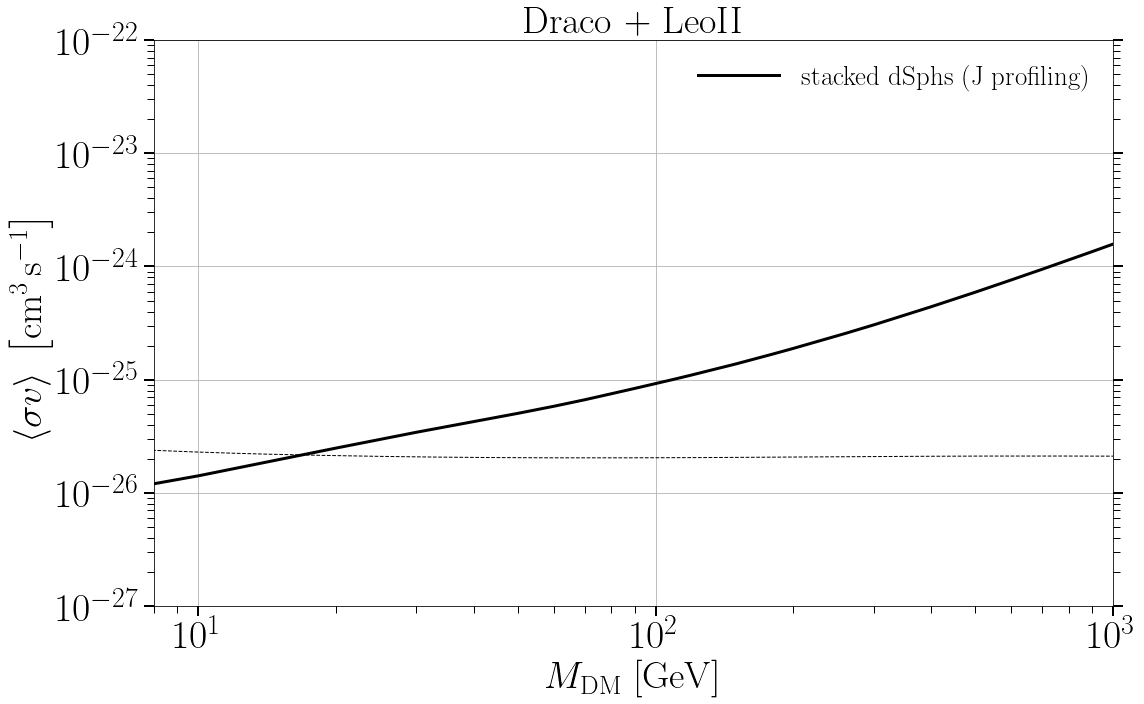

In [45]:
dplot.plot_limits_scan(root = root, 
                       dwarf_list = dwarf_list, 
                       case = case, 
                       plot_type = plot_type,
)

## Application: Reproducing Fig. 5 of [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004)

The results in this publication are based on four prominent dwarf spheroidal galaxies: Draco, Sculptor, LeoII and UrsaMinor. For these dwarfs, we have empirical $J$-factors, which we will employ in order to obtain annihilation cross-section upper limits rather agnostic on any a priori assumptions about the functional shape of background or $J$-factor probability distributions with respect to each dwarf.

The final plots contain the combined as well as single dwarf limits so that we have to derive all of them before plotting them all together!

### Left panel: $J$-profiling

In [46]:
case = "J"
dwarf_list = ["Draco", "LeoII", "Sculptor", "UrsaMinor"]

dwarf_data = dprof.getdSphs_data_from_table("default_dwarf_summary_table.dat", 29)
emp_jlist = "Jfactors"
is_empirical = True
spectrum = None
filescan = "scan_DM_mass.dat"
svmin = 1e-27 
svmax = 1e-22 
bkg_path = source_path + "bkg_data_optimal/"
ncpu = mp.cpu_count() 

dprof.profiling(dwarf_data, 
                dwarf_list = dwarf_list,
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

++++ this is dwarf #  Draco++++ this is dwarf # ++++ this is dwarf #     sv = Draco Draco 1e-27  sv = 
++++ this is dwarf #  ++++ this is dwarf #  1e-27++++ this is dwarf # Draco  sv =  Draco   sv =  LeoII1e-27
 sv = ++++ this is dwarf #  
++++ this is dwarf # LeoII  1e-27 
 sv = ++++ this is dwarf # ++++ this is dwarf #  sv = ++++ this is dwarf #     Draco1e-271e-27

++++ this is dwarf #  Sculptor  sv =  1e-27++++ this is dwarf #   LeoIILeoII
++++ this is dwarf # Sculptor   UrsaMinor sv =     sv =   sv = 1e-271e-27  Draco   sv =  ++++ this is dwarf # 1e-27 sv = 
 1e-27
 sv =  

 1e-27++++ this is dwarf #  ++++ this is dwarf # Draco++++ this is dwarf #  
1e-27 UrsaMinor  ++++ this is dwarf # Sculptor sv =  
LeoII  1e-27  sv =  sv = 
 ++++ this is dwarf #  1e-27 1e-27LeoII
++++ this is dwarf # 
 ++++ this is dwarf #  sv =    UrsaMinor Sculptor++++ this is dwarf # UrsaMinor  1e-27Sculptor sv = 
 ++++ this is dwarf #   1e-27 sv = LeoII 
1e-27
++++ this is dwarf #    sv =  1e-27 sv = 
++++

++++ this is dwarf #  Draco  sv =  2.5353644939701167e-27
++++ this is dwarf #  LeoII  sv =  2.5353644939701167e-27
++++ this is dwarf #  Sculptor  sv =  2.5353644939701167e-27
++++ this is dwarf #  UrsaMinor  sv =  2.5353644939701167e-27
++++ this is dwarf #  Draco  sv =  2.8480358684357933e-27
++++ this is dwarf #  LeoII  sv =  2.8480358684357933e-27
++++ this is dwarf #  Sculptor  sv =  2.8480358684357933e-27
++++ this is dwarf #  UrsaMinor  sv =  2.8480358684357933e-27
++++ this is dwarf #  Draco  sv =  2.8480358684357933e-27
++++ this is dwarf #  LeoII  sv =  2.8480358684357933e-27
++++ this is dwarf #  Sculptor  sv =  2.8480358684357933e-27
++++ this is dwarf #  UrsaMinor  sv =  2.8480358684357933e-27
++++ this is dwarf #  Draco ++++ this is dwarf #  sv =  Draco   sv =  2.8480358684357933e-272.8480358684357933e-27

++++ this is dwarf # ++++ this is dwarf #  LeoII  sv =  2.8480358684357933e-27 
LeoII  sv =  2.8480358684357933e-27++++ this is dwarf # 
 ++++ this is dwarf # Sculptor

++++ this is dwarf #  ++++ this is dwarf # UrsaMinor Sculptor   sv =  sv =   7.220809018385456e-277.220809018385456e-27

++++ this is dwarf #  UrsaMinor  sv =  7.220809018385456e-27
++++ this is dwarf #  Draco  sv =  7.220809018385456e-27
++++ this is dwarf #  LeoII  sv =  7.220809018385456e-27
++++ this is dwarf #  Sculptor  sv =  7.220809018385456e-27
++++ this is dwarf #  UrsaMinor  sv =  7.220809018385456e-27
++++ this is dwarf #  Draco  sv =  7.220809018385456e-27
++++ this is dwarf #  LeoII  sv =  7.220809018385456e-27
++++ this is dwarf #  Sculptor  sv =  7.220809018385456e-27
++++ this is dwarf #  UrsaMinor ++++ this is dwarf #  sv =   Draco7.220809018385456e-27
  sv =  7.220809018385456e-27
++++ this is dwarf #  LeoII  sv =  7.220809018385456e-27
++++ this is dwarf #  Sculptor  sv =  7.220809018385456e-27
++++ this is dwarf #  UrsaMinor  sv =  7.220809018385456e-27
++++ this is dwarf #  Draco  sv =  8.111308307896888e-27
++++ this is dwarf #  LeoII  sv =  8.111308307896888e-27

 LeoII  sv =  2.0565123083486598e-26
++++ this is dwarf #  Sculptor  sv =  2.0565123083486598e-26
++++ this is dwarf #  UrsaMinor  sv =  2.0565123083486598e-26
++++ this is dwarf #  Draco  sv =  2.0565123083486598e-26
++++ this is dwarf #  LeoII  sv =  2.0565123083486598e-26
++++ this is dwarf #  Sculptor  sv =  2.0565123083486598e-26
++++ this is dwarf #  UrsaMinor  sv =  2.0565123083486598e-26
++++ this is dwarf #  Draco  sv =  2.0565123083486598e-26
++++ this is dwarf # ++++ this is dwarf #  Draco   sv =  LeoII2.0565123083486598e-26
 ++++ this is dwarf #  sv =  2.0565123083486598e-26 LeoII  sv = 
 ++++ this is dwarf # 2.0565123083486598e-26
 Sculptor  sv = ++++ this is dwarf #   Sculptor2.0565123083486598e-26 
++++ this is dwarf #  UrsaMinor  sv =  sv =   2.0565123083486598e-262.0565123083486598e-26

++++ this is dwarf # ++++ this is dwarf #   Draco  sv =  2.0565123083486598e-26
++++ this is dwarf #  LeoII UrsaMinor sv =  2.0565123083486598e-26 
 sv = ++++ this is dwarf #   2.056512

++++ this is dwarf #  LeoII  sv =  5.214008287999674e-26
++++ this is dwarf #  Sculptor  sv =  5.214008287999674e-26
++++ this is dwarf #  UrsaMinor  sv =  5.214008287999674e-26
++++ this is dwarf #  Draco  sv =  5.214008287999674e-26
++++ this is dwarf #  LeoII  sv =  5.214008287999674e-26
++++ this is dwarf # ++++ this is dwarf #  Sculptor   sv = Draco   sv =  5.214008287999674e-26
++++ this is dwarf #  UrsaMinor  sv =  5.214008287999674e-26
5.857020818056673e-26
++++ this is dwarf #  LeoII  sv =  5.857020818056673e-26
++++ this is dwarf #  Sculptor  sv =  5.857020818056673e-26
++++ this is dwarf #  UrsaMinor  sv =  5.857020818056673e-26
++++ this is dwarf #  Draco  sv =  5.857020818056673e-26
++++ this is dwarf #  LeoII  sv =  5.857020818056673e-26
++++ this is dwarf #  Sculptor  sv =  5.857020818056673e-26
++++ this is dwarf #  UrsaMinor  sv =  5.857020818056673e-26
++++ this is dwarf #  Draco  sv =  5.214008287999674e-26
++++ this is dwarf #  LeoII  sv =  5.214008287999674e-26
+++

++++ this is dwarf #  Sculptor  sv =  2.104904144512013e-25
++++ this is dwarf #  UrsaMinor  sv =  2.104904144512013e-25
++++ this is dwarf #  Draco  sv =  1.3219411484660288e-25
++++ this is dwarf #  LeoII  sv =  1.3219411484660288e-25
++++ this is dwarf #  Sculptor  sv =  1.3219411484660288e-25
++++ this is dwarf #  UrsaMinor  sv =  1.3219411484660288e-25
++++ this is dwarf #  Draco  sv =  1.8738174228603869e-25
++++ this is dwarf #  LeoII  sv =  1.8738174228603869e-25
++++ this is dwarf #  Sculptor  sv =  1.8738174228603869e-25
++++ this is dwarf #  UrsaMinor  sv =  1.8738174228603869e-25
++++ this is dwarf #  Draco  sv =  1.4849682622544697e-25
++++ this is dwarf #  LeoII  sv =  1.4849682622544697e-25
++++ this is dwarf #  Sculptor ++++ this is dwarf #  sv =   Draco 1.4849682622544697e-25 sv =  1.3219411484660288e-25

++++ this is dwarf #  LeoII ++++ this is dwarf #  sv =   1.3219411484660288e-25UrsaMinor
++++ this is dwarf #    sv =  Sculptor  sv = 1.4849682622544697e-25
 1.321941

++++ this is dwarf #   Sculptor  sv =  sv =  2.983647240283334e-25 
3.3516026509388476e-25
++++ this is dwarf #  UrsaMinor  sv =  3.3516026509388476e-25
++++ this is dwarf #  Draco  sv =  4.750810162102813e-25++++ this is dwarf # 
++++ this is dwarf #   LeoII  sv = Draco 4.750810162102813e-25
++++ this is dwarf #  Sculptor  sv =    sv = 7.564633275546291e-25 
4.750810162102813e-25
++++ this is dwarf #  UrsaMinor++++ this is dwarf #  LeoII  sv =  7.564633275546291e-25
++++ this is dwarf #    sv =  Sculptor4.750810162102813e-25
  sv =  7.564633275546291e-25
++++ this is dwarf #  UrsaMinor  sv =  7.564633275546291e-25
++++ this is dwarf #  Draco  sv =  2.983647240283334e-25
++++ this is dwarf #  LeoII  sv =  2.983647240283334e-25
++++ this is dwarf #  Sculptor  sv =  2.983647240283334e-25
++++ this is dwarf #  UrsaMinor  sv =  2.983647240283334e-25
++++ this is dwarf #  Draco  sv =  3.764935806792456e-25
++++ this is dwarf #  LeoII  sv =  3.764935806792456e-25
++++ this is dwarf #  Sculpt

++++ this is dwarf #  
++++ this is dwarf # LeoII   Sculptor sv =   sv =   sv =  4.229242874389499e-25 1.2045035402587788e-24
++++ this is dwarf #  Sculptor  sv =  
++++ this is dwarf #  UrsaMinor  sv =  1.2045035402587788e-24
1.3530477745798076e-244.229242874389499e-25
++++ this is dwarf #  ++++ this is dwarf # 
++++ this is dwarf #  UrsaMinor   sv = Sculptor  sv =  1.3530477745798076e-24
++++ this is dwarf #  UrsaMinor  sv =   4.229242874389499e-251.3530477745798076e-24
Draco++++ this is dwarf #   Draco  sv =  9.545484566618328e-25
 sv = 
++++ this is dwarf #  5.336699231206302e-25
++++ this is dwarf #  LeoII  sv = ++++ this is dwarf #   5.336699231206302e-25
++++ this is dwarf #  SculptorDraco  sv =  4.750810162102813e-25
++++ this is dwarf #  LeoII  sv =    LeoII  sv = 4.750810162102813e-25 sv = 
++++ this is dwarf #    9.545484566618328e-25
++++ this is dwarf #  5.336699231206302e-25Sculptor Sculptor  sv =  
4.750810162102813e-25 sv = 
++++ this is dwarf #  ++++ this is dwarf #  U

++++ this is dwarf #  Sculptor++++ this is dwarf #  Draco ++++ this is dwarf #    sv =  sv =  ++++ this is dwarf #    Draco3.430469286314926e-24 
++++ this is dwarf # 9.545484566618328e-25
++++ this is dwarf #  LeoIIUrsaMinor   sv =  sv = Draco 3.430469286314926e-24
  sv =   sv =  9.545484566618328e-25
++++ this is dwarf # 1.519911082952927e-24 Sculptor  sv =   
9.545484566618328e-25++++ this is dwarf # 
++++ this is dwarf #   LeoII9.545484566618328e-25LeoII   sv =  sv =  
 ++++ this is dwarf #  UrsaMinor  sv =  1.519911082952927e-249.545484566618328e-259.545484566618328e-25

++++ this is dwarf #  Sculptor ++++ this is dwarf #  sv =  
 Sculptor1.519911082952927e-24
 ++++ this is dwarf #  sv =   9.545484566618328e-25
++++ this is dwarf # UrsaMinor  sv =   1.519911082952927e-24UrsaMinor
  sv =  9.545484566618328e-25
++++ this is dwarf #  Draco  sv =  2.718588242732929e-24
++++ this is dwarf #  LeoII  sv =  2.718588242732929e-24
++++ this is dwarf #  Sculptor  sv =  2.718588242732929e-24


Draco ++++ this is dwarf # UrsaMinor    sv =  sv =  6.892612104349681e-24++++ this is dwarf #  LeoII
1.097498765493059e-23
 ++++ this is dwarf #  sv =  LeoII  sv =  6.892612104349681e-24
++++ this is dwarf #  Sculptor  sv =    Draco 6.892612104349681e-244.862601580065334e-24

++++ this is dwarf #  sv =   9.770099572992247e-24++++ this is dwarf # 
++++ this is dwarf #  LeoII  sv = UrsaMinor 
  sv =  Sculptor  sv =  4.862601580065334e-24++++ this is dwarf #  9.770099572992247e-24
++++ this is dwarf #  UrsaMinor  sv =  4.862601580065334e-24
6.892612104349681e-24 
Sculptor  sv =  9.770099572992247e-24
++++ this is dwarf #  UrsaMinor  sv =  9.770099572992247e-24
++++ this is dwarf #  Draco  sv =  2.718588242732929e-24
++++ this is dwarf #  LeoII  sv =  2.718588242732929e-24
++++ this is dwarf #  Sculptor  sv =  2.718588242732929e-24
++++ this is dwarf #  UrsaMinor  sv = ++++ this is dwarf #  2.718588242732929e-24
 Draco  sv =  3.8535285937105195e-24++++ this is dwarf # 
++++ this is dwarf #

++++ this is dwarf #  LeoII  sv =  9.770099572992247e-24
++++ this is dwarf # ++++ this is dwarf #  Draco  Sculptor sv =   sv =  9.770099572992247e-24 
1.097498765493059e-23++++ this is dwarf # 
++++ this is dwarf #  UrsaMinor  sv =  9.770099572992247e-24
 LeoII  sv =  1.097498765493059e-23
++++ this is dwarf #  Sculptor  sv =  1.097498765493059e-23
++++ this is dwarf #  UrsaMinor  sv =  ++++ this is dwarf # 1.097498765493059e-23 
Draco  sv =  2.782559402207115e-23
++++ this is dwarf #  ++++ this is dwarf #  LeoIIDraco  sv =   sv =   2.782559402207115e-23
7.742636826811278e-24++++ this is dwarf #  Sculptor
++++ this is dwarf #  LeoII  sv =   7.742636826811278e-24 sv = 
++++ this is dwarf #   2.782559402207115e-23
Sculptor  sv = ++++ this is dwarf #   UrsaMinor7.742636826811278e-24  sv = 
++++ this is dwarf #  ++++ this is dwarf # 2.782559402207115e-23
  Draco  sv =  2.477076355991714e-23UrsaMinor  sv =  7.742636826811278e-24

++++ this is dwarf #  LeoII  sv =  2.477076355991714e-23
+++

++++ this is dwarf # Sculptor  sv =  2.2051307399030412e-23
++++ this is dwarf # ++++ this is dwarf #  UrsaMinor Draco   sv =   sv = 5.590810182512223e-23
++++ this is dwarf #   2.2051307399030412e-23LeoII  sv =  
5.590810182512223e-23
++++ this is dwarf #  Sculptor  sv =  5.590810182512223e-23
++++ this is dwarf #  UrsaMinor  sv =  5.590810182512223e-23
++++ this is dwarf #  Draco  sv =  6.280291441834273e-23
++++ this is dwarf #  LeoII  sv =  6.280291441834273e-23
++++ this is dwarf #  Sculptor  sv =  6.280291441834273e-23
++++ this is dwarf #  UrsaMinor  sv =  6.280291441834273e-23
++++ this is dwarf #  Draco  sv =  3.125715849688235e-23
++++ this is dwarf #  LeoII  sv =  ++++ this is dwarf # 3.125715849688235e-23
++++ this is dwarf #  Sculptor  sv =  3.125715849688235e-23
++++ this is dwarf #  UrsaMinor  sv =  3.125715849688235e-23 
Draco  sv =  3.511191734215142e-23
++++ this is dwarf #  LeoII  sv =  3.511191734215142e-23
++++ this is dwarf #  ++++ this is dwarf # Draco Sculptor  

++++ this is dwarf #  UrsaMinor  sv =  1.2618568830660184e-27
++++ this is dwarf #  Draco  sv =  1e-22
++++ this is dwarf #  LeoII  sv =  1e-22
++++ this is dwarf #  Sculptor  sv =  1e-22
++++ this is dwarf #  UrsaMinor  sv =  1e-22
++++ this is dwarf #  Draco  sv =  7.924828983539185e-23
++++ this is dwarf #  LeoII  sv =  7.924828983539185e-23
++++ this is dwarf #  Sculptor  sv =  7.924828983539185e-23
++++ this is dwarf #  UrsaMinor  sv =  7.924828983539185e-23
++++ this is dwarf #  Draco  sv =  7.924828983539185e-23
++++ this is dwarf #  LeoII  sv =  ++++ this is dwarf # 7.924828983539185e-23 
++++ this is dwarf # Draco   ++++ this is dwarf # Sculptor  sv =   sv = 1e-22 Draco 7.924828983539185e-23

++++ this is dwarf # ++++ this is dwarf #   sv = Draco++++ this is dwarf #     LeoII UrsaMinor1e-27 sv =  sv =  
 sv =    1.1233240329780312e-271e-22++++ this is dwarf #  7.924828983539185e-23


++++ this is dwarf #  SculptorLeoII++++ this is dwarf #     sv =  sv =  LeoII  sv =  1e-221e-2

++++ this is dwarf #  Draco  sv =  3.1992671377973845e-27
++++ this is dwarf #  LeoII  sv =  3.1992671377973845e-27
++++ this is dwarf #  Sculptor  sv =  3.1992671377973845e-27
++++ this is dwarf #  UrsaMinor  sv =  3.1992671377973845e-27
++++ this is dwarf #  Draco  sv =  3.593813663804641e-27
++++ this is dwarf #  LeoII  sv =  3.593813663804641e-27
++++ this is dwarf #  Sculptor  sv =  3.593813663804641e-27
++++ this is dwarf #  UrsaMinor  sv =  3.593813663804641e-27
++++ this is dwarf #  Draco  sv =  2.009233002565054e-27
++++ this is dwarf #  LeoII  sv =  2.009233002565054e-27
++++ this is dwarf #  Sculptor  sv =  2.009233002565054e-27
++++ this is dwarf #  UrsaMinor  sv =  2.009233002565054e-27
++++ this is dwarf #  Draco  sv =  3.1992671377973845e-27
++++ this is dwarf #  LeoII  sv =  3.1992671377973845e-27
++++ this is dwarf #  Sculptor  sv =  3.1992671377973845e-27
++++ this is dwarf #  UrsaMinor  sv =  3.1992671377973845e-27
++++ this is dwarf #  Draco  sv =  2.535364493970116

 6.4280731172843454e-27
++++ this is dwarf #  Sculptor  sv =  8.111308307896888e-27
++++ this is dwarf #  UrsaMinor  sv =  8.111308307896888e-27
++++ this is dwarf #  Draco  sv =  5.72236765935022e-27
++++ this is dwarf #  LeoII  sv =  5.72236765935022e-27
++++ this is dwarf #  Sculptor  sv =  5.72236765935022e-27
++++ this is dwarf #  UrsaMinor  sv =  5.72236765935022e-27
++++ this is dwarf #  Draco  sv =  7.220809018385456e-27
++++ this is dwarf #  LeoII  sv =  7.220809018385456e-27
++++ this is dwarf #  Sculptor  sv =  7.220809018385456e-27
++++ this is dwarf #  UrsaMinor  sv =  7.220809018385456e-27
++++ this is dwarf #  Draco  sv =  5.72236765935022e-27
++++ this is dwarf #  LeoII  sv =  5.72236765935022e-27
++++ this is dwarf #  Sculptor  sv =  5.72236765935022e-27
++++ this is dwarf #  UrsaMinor  sv =  5.72236765935022e-27
++++ this is dwarf #  Draco  sv =  9.111627561154868e-27
++++ this is dwarf #  LeoII  sv =  9.111627561154868e-27
++++ this is dwarf #  Sculptor  sv =  9.1116

++++ this is dwarf #  Sculptor  sv =  ++++ this is dwarf # 2.5950242113997423e-26
++++ this is dwarf #  UrsaMinor  sv =  2.5950242113997423e-26
 Draco  sv =  2.310129700083158e-26
++++ this is dwarf #  LeoII  sv =  2.310129700083158e-26
++++ this is dwarf #  Sculptor  sv =  2.310129700083158e-26
++++ this is dwarf #  UrsaMinor  sv =  2.310129700083158e-26
++++ this is dwarf #  Draco  sv =  1.8307382802953696e-26
++++ this is dwarf #  LeoII  sv =  1.8307382802953696e-26
++++ this is dwarf #  Sculptor  sv =  1.8307382802953696e-26
++++ this is dwarf #  UrsaMinor  sv =  1.8307382802953696e-26
++++ this is dwarf #  Draco  sv =  2.0565123083486598e-26
++++ this is dwarf #  LeoII  sv =  2.0565123083486598e-26
++++ this is dwarf #  Sculptor  sv =  2.0565123083486598e-26
++++ this is dwarf #  UrsaMinor  sv =  2.0565123083486598e-26
++++ this is dwarf #  Draco  sv =  1.8307382802953696e-26
++++ this is dwarf #  LeoII  sv =  1.8307382802953696e-26
++++ this is dwarf #  Sculptor  sv =  1.83073828

++++ this is dwarf #  LeoII  sv =  6.579332246575655e-26
++++ this is dwarf #  Sculptor  sv =  6.579332246575655e-26
++++ this is dwarf #  UrsaMinor  sv =  6.579332246575655e-26
++++ this is dwarf #  Draco  sv =  6.579332246575655e-26
++++ this is dwarf #  LeoII  sv =  6.579332246575655e-26
++++ this is dwarf #  Sculptor  sv =  6.579332246575655e-26
++++ this is dwarf #  UrsaMinor++++ this is dwarf #   sv =   6.579332246575655e-26Draco
  sv =  4.1320124001153346e-26
++++ this is dwarf #  LeoII  sv =  4.1320124001153346e-26
++++ this is dwarf #  ++++ this is dwarf #  DracoSculptor   sv =  sv =  7.390722033525776e-26
 ++++ this is dwarf #  4.1320124001153346e-26LeoII  sv =  7.390722033525776e-26

++++ this is dwarf # ++++ this is dwarf #  Sculptor  UrsaMinor sv =  7.390722033525776e-26 
++++ this is dwarf #  UrsaMinor  sv =  7.390722033525776e-26 sv = 
 ++++ this is dwarf # 4.1320124001153346e-26
 Draco  sv =  4.1320124001153346e-26
++++ this is dwarf #  LeoII  sv =  4.1320124001153346e-

++++ this is dwarf #  Sculptor  sv =  1.4849682622544697e-25
++++ this is dwarf #  UrsaMinor  sv =  1.4849682622544697e-25
++++ this is dwarf #  Draco  sv =  1.3219411484660288e-25
++++ this is dwarf #  LeoII  sv =  1.3219411484660288e-25
++++ this is dwarf #  Sculptor  sv =  1.3219411484660288e-25
++++ this is dwarf #  UrsaMinor  sv =  1.3219411484660288e-25
++++ this is dwarf #  Draco  sv = ++++ this is dwarf #   1.3219411484660288e-25
Draco ++++ this is dwarf #  sv =  LeoII  sv =  1.3219411484660288e-25
++++ this is dwarf #  Sculptor   sv = 2.104904144512013e-25
 1.3219411484660288e-25++++ this is dwarf # 
 ++++ this is dwarf #  UrsaMinor  sv =  LeoII  sv = 1.3219411484660288e-25
 2.104904144512013e-25
++++ this is dwarf #  Sculptor  sv =  2.104904144512013e-25
++++ this is dwarf #  UrsaMinor  sv =  2.104904144512013e-25
++++ this is dwarf #  Draco  sv =  1.8738174228603869e-25
++++ this is dwarf #  LeoII  sv =  1.8738174228603869e-25
++++ this is dwarf #  Sculptor  sv =  1.87381742

++++ this is dwarf #  LeoII  sv =  4.750810162102813e-25
++++ this is dwarf #  Sculptor  sv =  4.750810162102813e-25
++++ this is dwarf #  UrsaMinor  sv =  4.750810162102813e-25
++++ this is dwarf #  Draco  sv =  4.229242874389499e-25
++++ this is dwarf #  LeoII  sv =  4.229242874389499e-25
++++ this is dwarf #  Sculptor  sv =  4.229242874389499e-25
++++ this is dwarf #  UrsaMinor  sv =  4.229242874389499e-25
++++ this is dwarf #  Draco  sv =  2.983647240283334e-25
++++ this is dwarf #  LeoII  sv =  2.983647240283334e-25
++++ this is dwarf #  Sculptor  sv =  2.983647240283334e-25
++++ this is dwarf #  UrsaMinor  sv =  2.983647240283334e-25
++++ this is dwarf #  Draco  sv =  2.983647240283334e-25
++++ this is dwarf #  LeoII  sv =  2.983647240283334e-25
++++ this is dwarf #  Sculptor  sv =  2.983647240283334e-25
++++ this is dwarf #  UrsaMinor  sv =  2.983647240283334e-25
++++ this is dwarf #  Draco  sv =  3.764935806792456e-25
++++ this is dwarf #  LeoII  sv =  3.764935806792456e-25
+++

++++ this is dwarf #  Sculptor  sv =  7.564633275546291e-25
++++ this is dwarf #  UrsaMinor  sv =  7.564633275546291e-25
++++ this is dwarf #  Draco  sv =  9.545484566618328e-25
++++ this is dwarf # ++++ this is dwarf #   DracoLeoII   sv =  sv =  9.545484566618328e-25
++++ this is dwarf #  Sculptor  sv =  9.545484566618328e-25
++++ this is dwarf #  UrsaMinor  sv =  9.545484566618328e-25
 1.0722672220103254e-24
++++ this is dwarf #  LeoII  sv =  1.0722672220103254e-24
++++ this is dwarf #  Sculptor  sv =  1.0722672220103254e-24
++++ this is dwarf #  UrsaMinor  sv =  1.0722672220103254e-24
++++ this is dwarf #  Draco  sv =  1.3530477745798076e-24
++++ this is dwarf #  LeoII  sv =  1.3530477745798076e-24
++++ this is dwarf #  Sculptor  sv =  1.3530477745798076e-24
++++ this is dwarf #  UrsaMinor  sv = 1.3530477745798076e-24 
++++ this is dwarf #  Draco  sv =  2.1544346900318778e-24
++++ this is dwarf #  LeoII  sv =  2.1544346900318778e-24
++++ this is dwarf #  Sculptor  sv =  2.1544346900

++++ this is dwarf #  LeoII  sv =  4.862601580065334e-24
++++ this is dwarf #  Sculptor  sv =  4.862601580065334e-24
++++ this is dwarf #  UrsaMinor  sv =  4.862601580065334e-24
++++ this is dwarf #  Draco  sv =  2.1544346900318778e-24
++++ this is dwarf #  LeoII  sv =  2.1544346900318778e-24
++++ this is dwarf #  Sculptor  sv = ++++ this is dwarf #   Draco2.1544346900318778e-24
 ++++ this is dwarf #  sv =  UrsaMinor  1.7073526474706888e-24
 sv =  2.1544346900318778e-24++++ this is dwarf # ++++ this is dwarf #  
LeoII Draco  sv =  1.7073526474706888e-24
++++ this is dwarf #  LeoII  sv =  1.7073526474706888e-24
++++ this is dwarf #  Sculptor   sv =  1.7073526474706888e-24
++++ this is dwarf #  UrsaMinor  sv =  1.7073526474706888e-24
 sv =  1.7073526474706888e-24
++++ this is dwarf #  Sculptor  sv =  1.7073526474706888e-24
++++ this is dwarf #  UrsaMinor  sv =  1.7073526474706888e-24
++++ this is dwarf # ++++ this is dwarf #  Draco  sv =  4.3287612810830616e-24
++++ this is dwarf #  LeoI

++++ this is dwarf #  LeoII  sv =  9.770099572992247e-24
++++ this is dwarf #  Sculptor  sv =  9.770099572992247e-24
++++ this is dwarf #  UrsaMinor  sv =  9.770099572992247e-24
++++ this is dwarf #  Draco  sv =  1.2328467394420634e-23
++++ this is dwarf #  LeoII  sv =  1.2328467394420634e-23
++++ this is dwarf #  Sculptor  sv =  1.2328467394420634e-23
++++ this is dwarf #  UrsaMinor  sv =  1.2328467394420634e-23
++++ this is dwarf #  Draco  sv =  6.135907273413189e-24
++++ this is dwarf #  LeoII  sv =  6.135907273413189e-24
++++ this is dwarf #  Sculptor  sv =  6.135907273413189e-24
++++ this is dwarf #  UrsaMinor  sv =  6.135907273413189e-24
++++ this is dwarf #  Draco  sv =  2.2051307399030412e-23
++++ this is dwarf #  LeoII  sv =  2.2051307399030412e-23
++++ this is dwarf #  Sculptor  sv =  2.2051307399030412e-23
++++ this is dwarf #  UrsaMinor  sv =  2.2051307399030412e-23
++++ this is dwarf #  Draco  sv =  3.430469286314926e-24
++++ this is dwarf #  LeoII  sv =  3.430469286314926

 Sculptor   sv = 6.280291441834273e-23
++++ this is dwarf #  UrsaMinor  sv =  ++++ this is dwarf #  Draco6.280291441834273e-23 
 sv =  3.944206059437648e-23
++++ this is dwarf #  LeoII  sv =  3.944206059437648e-23
++++ this is dwarf #  Sculptor  sv =  3.944206059437648e-23
++++ this is dwarf #  UrsaMinor  sv =  3.944206059437648e-23
++++ this is dwarf #  Draco  sv =  8.697490026177799e-24
++++ this is dwarf #  LeoII  sv =  8.697490026177799e-24
++++ this is dwarf #  Sculptor  sv =  8.697490026177799e-24
++++ this is dwarf #  UrsaMinor  sv =  8.697490026177799e-24
++++ this is dwarf #  Draco  sv =  2.477076355991714e-23
++++ this is dwarf #  LeoII  sv =  2.477076355991714e-23
++++ this is dwarf #  Sculptor  sv =  2.477076355991714e-23
++++ this is dwarf #  UrsaMinor ++++ this is dwarf #   sv =  Draco2.477076355991714e-23
++++ this is dwarf #  Draco  sv =    sv =  1.747528400007683e-23
3.511191734215142e-23++++ this is dwarf # 
 ++++ this is dwarf # LeoII  sv =  1.747528400007683e-23
 ++

++++ this is dwarf #  UrsaMinor  sv =  4.9770235643320934e-23
++++ this is dwarf #  ++++ this is dwarf #  Draco  sv =  1e-27Draco
 ++++ this is dwarf #  LeoII  sv =  1e-27
++++ this is dwarf #  sv =   Sculptor1e-22  sv = 
 ++++ this is dwarf #  1e-27LeoII  sv = 
++++ this is dwarf #   1e-22
UrsaMinor++++ this is dwarf #    sv =  Sculptor1e-27 
 sv =  1e-22
++++ this is dwarf #  UrsaMinor  sv =  1e-22
++++ this is dwarf #  Draco  sv =  2.477076355991714e-23
++++ this is dwarf #  LeoII  sv =  ++++ this is dwarf # 2.477076355991714e-23
++++ this is dwarf #   Draco Sculptor sv =   sv =  7.054802310718631e-23 
2.477076355991714e-23++++ this is dwarf # 
 ++++ this is dwarf # LeoII   sv =  7.054802310718631e-23
UrsaMinor++++ this is dwarf #    sv = Sculptor   sv = 2.477076355991714e-23 
7.054802310718631e-23
++++ this is dwarf #  UrsaMinor  sv =  7.054802310718631e-23
++++ this is dwarf #  Draco  sv =  4.9770235643320934e-23
++++ this is dwarf # ++++ this is dwarf #  LeoII  sv =  4.9770235643

++++ this is dwarf # ++++ this is dwarf #  Sculptor  sv =   LeoII2.257019719633917e-27  sv = 
 ++++ this is dwarf #  UrsaMinor1.4174741629268077e-27  sv =  
++++ this is dwarf #  Sculptor  sv =  1.4174741629268077e-27
2.257019719633917e-27
++++ this is dwarf #  UrsaMinor  sv =  1.4174741629268077e-27
++++ this is dwarf #  Draco  sv =  2.8480358684357933e-27
++++ this is dwarf #  LeoII  sv =  2.8480358684357933e-27
++++ this is dwarf #  Sculptor  sv =  2.8480358684357933e-27
++++ this is dwarf #  UrsaMinor  sv =  2.8480358684357933e-27
++++ this is dwarf #  Draco  sv =  8.902150854450356e-23
++++ this is dwarf #  LeoII  sv =  8.902150854450356e-23
++++ this is dwarf #  Sculptor  sv =  8.902150854450356e-23
++++ this is dwarf #  UrsaMinor  sv =  8.902150854450356e-23
++++ this is dwarf #  Draco  sv =  1e-27
++++ this is dwarf #  LeoII  sv =  1e-27
++++ this is dwarf #  Sculptor  sv =  1e-27++++ this is dwarf # 
++++ this is dwarf #  UrsaMinor  sv =   Draco 1e-27
 sv =  1.788649529057435e

++++ this is dwarf #  Sculptor  sv =  4.5348785081285914e-27
++++ this is dwarf #  UrsaMinor ++++ this is dwarf #  Draco  sv =  sv =  ++++ this is dwarf # 4.5348785081285914e-27 5.72236765935022e-27
 
Draco++++ this is dwarf #    sv = LeoII  sv =   5.72236765935022e-276.4280731172843454e-27

++++ this is dwarf #  ++++ this is dwarf #  LeoIISculptor  sv =  5.72236765935022e-27
  sv = ++++ this is dwarf #   UrsaMinor 6.4280731172843454e-27 sv = 
 ++++ this is dwarf #  Sculptor5.72236765935022e-27
  sv =  6.4280731172843454e-27
++++ this is dwarf # ++++ this is dwarf #   UrsaMinorDraco  sv =    sv =  3.593813663804641e-27
6.4280731172843454e-27
++++ this is dwarf #  LeoII  sv =  3.593813663804641e-27
++++ this is dwarf #  Sculptor  sv =  3.593813663804641e-27
++++ this is dwarf #  UrsaMinor  sv =  3.593813663804641e-27
++++ this is dwarf #  Draco  sv =  4.03701725859655e-27
++++ this is dwarf #  LeoII  sv =  4.03701725859655e-27
++++ this is dwarf #  Sculptor  sv =  4.03701725859655e-27
+

++++ this is dwarf #  LeoII ++++ this is dwarf #  sv =  Draco   sv =  1.62975083462064e-262.0565123083486598e-26
++++ this is dwarf #  
++++ this is dwarf # LeoII   sv =  1.62975083462064e-26
++++ this is dwarf #  SculptorSculptor  sv =  2.0565123083486598e-26 
++++ this is dwarf #  UrsaMinor sv =    sv = 1.62975083462064e-26
 ++++ this is dwarf #  2.0565123083486598e-26
UrsaMinor  sv =  1.62975083462064e-26
++++ this is dwarf #  Draco  sv =  1.2915496650148827e-26
++++ this is dwarf #  LeoII  sv =  1.2915496650148827e-26
++++ this is dwarf #  Sculptor  sv =  1.2915496650148827e-26
++++ this is dwarf #  UrsaMinor  sv =  1.2915496650148827e-26
++++ this is dwarf #  Draco  sv =  7.220809018385456e-27
++++ this is dwarf #  LeoII  sv =  7.220809018385456e-27
++++ this is dwarf #  Sculptor  sv =  7.220809018385456e-27
++++ this is dwarf #  UrsaMinor  sv =  7.220809018385456e-27
++++ this is dwarf #  Draco  sv =  6.4280731172843454e-27
++++ this is dwarf #  LeoII  sv =  6.4280731172843454e-2

++++ this is dwarf #  Draco  sv =  2.9150530628251697e-26
++++ this is dwarf #  LeoII  sv =  2.9150530628251697e-26
++++ this is dwarf #  Sculptor  sv =  2.9150530628251697e-26
++++ this is dwarf #  UrsaMinor  sv =  2.9150530628251697e-26
++++ this is dwarf #  Draco  sv =  1.62975083462064e-26
++++ this is dwarf #  LeoII  sv =  1.62975083462064e-26
++++ this is dwarf #  Sculptor  sv =  1.62975083462064e-26
++++ this is dwarf #  UrsaMinor  sv =  1.62975083462064e-26
++++ this is dwarf #  Draco  sv =  4.641588833612792e-26
++++ this is dwarf #  LeoII  sv =  4.641588833612792e-26
++++ this is dwarf #  Sculptor  sv =  4.641588833612792e-26
++++ this is dwarf #  UrsaMinor  sv =  4.641588833612792e-26
++++ this is dwarf #  Draco  sv =  5.857020818056673e-26
++++ this is dwarf #  LeoII  sv =  5.857020818056673e-26
++++ this is dwarf #  Sculptor  sv =  5.857020818056673e-26
++++ this is dwarf #  UrsaMinor  sv =  5.857020818056673e-26
++++ this is dwarf #  Draco  sv =  3.6783797718286193e-26
++

++++ this is dwarf #  Draco  sv =  5.214008287999674e-26
++++ this is dwarf #  LeoII  sv =  5.214008287999674e-26
++++ this is dwarf #  Sculptor  sv = ++++ this is dwarf #   5.214008287999674e-26Draco
  sv =  1.1768119524349943e-25
++++ this is dwarf # ++++ this is dwarf #  UrsaMinor sv =   5.214008287999674e-26
 LeoII  sv =  1.1768119524349943e-25
++++ this is dwarf #  Sculptor  sv =  1.1768119524349943e-25
++++ this is dwarf #  UrsaMinor  sv =  1.1768119524349943e-25
++++ this is dwarf #  Draco  sv =  4.641588833612792e-26
++++ this is dwarf #  LeoII  sv =  4.641588833612792e-26
++++ this is dwarf #  Sculptor  sv =  4.641588833612792e-26
++++ this is dwarf #  ++++ this is dwarf # UrsaMinor  Draco sv =    sv = 4.641588833612792e-26 
7.390722033525776e-26
++++ this is dwarf #  LeoII  sv =  7.390722033525776e-26
++++ this is dwarf #  Sculptor  sv =  7.390722033525776e-26
++++ this is dwarf #  UrsaMinor  sv =  7.390722033525776e-26
++++ this is dwarf #  Draco  sv =  1.6681005372000557e-2

++++ this is dwarf #  Draco  sv =  1.1768119524349943e-25
++++ this is dwarf #  LeoII  sv =  1.1768119524349943e-25
++++ this is dwarf #  Sculptor  sv =  1.1768119524349943e-25
++++ this is dwarf #  UrsaMinor  sv =  1.1768119524349943e-25
++++ this is dwarf #  Draco  sv =  2.104904144512013e-25
++++ this is dwarf #  LeoII  sv =  2.104904144512013e-25
++++ this is dwarf #  Sculptor  sv =  2.104904144512013e-25
++++ this is dwarf #  UrsaMinor  sv =  2.104904144512013e-25
++++ this is dwarf #  Draco  sv =  3.3516026509388476e-25
++++ this is dwarf #  LeoII  sv =  3.3516026509388476e-25
++++ this is dwarf #  Sculptor  sv =  3.3516026509388476e-25
++++ this is dwarf #  UrsaMinor  sv =  3.3516026509388476e-25
++++ this is dwarf #  Draco  sv =  2.656087782946695e-25
++++ this is dwarf #  LeoII  sv =  2.656087782946695e-25
++++ this is dwarf #  Sculptor  sv =  2.656087782946695e-25
++++ this is dwarf #  UrsaMinor  sv =  2.656087782946695e-25
++++ this is dwarf #  ++++ this is dwarf #  Draco  s

++++ this is dwarf #  LeoII  sv =  1.2045035402587788e-24
++++ this is dwarf #  Sculptor  sv =  1.2045035402587788e-24
++++ this is dwarf #  UrsaMinor  sv =  1.2045035402587788e-24
++++ this is dwarf #  Draco  sv =  5.336699231206302e-25
++++ this is dwarf #  LeoII  sv =  5.336699231206302e-25
++++ this is dwarf #  Sculptor  sv =  5.336699231206302e-25
++++ this is dwarf #  UrsaMinor  sv =  5.336699231206302e-25
++++ this is dwarf #  Draco  sv =  3.764935806792456e-25
++++ this is dwarf #  LeoII  sv =  3.764935806792456e-25
++++ this is dwarf #  Sculptor  sv =  3.764935806792456e-25
++++ this is dwarf #  UrsaMinor  sv =  ++++ this is dwarf # 3.764935806792456e-25 
Draco  sv =  9.545484566618328e-25
++++ this is dwarf #  LeoII  sv =  9.545484566618328e-25
++++ this is dwarf #  Sculptor ++++ this is dwarf #  sv =   9.545484566618328e-25Draco
  sv =  ++++ this is dwarf # 5.994842503189421e-25 
UrsaMinor++++ this is dwarf #    sv = LeoII  9.545484566618328e-25 sv =  
5.994842503189421e-25


++++ this is dwarf #  LeoII  sv =  1.9179102616724927e-24
++++ this is dwarf #  Sculptor  sv =  1.9179102616724927e-24
++++ this is dwarf #  UrsaMinor  sv =  1.9179102616724927e-24
++++ this is dwarf #  Draco  sv =  8.497534359086404e-25
++++ this is dwarf #  LeoII  sv =  8.497534359086404e-25
++++ this is dwarf #  Sculptor  sv =  8.497534359086404e-25
++++ this is dwarf #  UrsaMinor  sv =  8.497534359086404e-25
++++ this is dwarf #  Draco  sv =  2.718588242732929e-24
++++ this is dwarf #  LeoII  sv =  2.718588242732929e-24
++++ this is dwarf #  Sculptor  sv =  2.718588242732929e-24
++++ this is dwarf #  UrsaMinor  sv =  2.718588242732929e-24
++++ this is dwarf #  Draco  sv =  ++++ this is dwarf #  ++++ this is dwarf #  1.519911082952927e-24
Draco  sv = ++++ this is dwarf # Draco   LeoII sv =   sv =   3.430469286314926e-24
++++ this is dwarf #  LeoII  sv =  3.430469286314926e-24
1.519911082952927e-24++++ this is dwarf # 
++++ this is dwarf # 2.718588242732929e-24  Sculptor
 Sculptor sv

 ++++ this is dwarf #  Sculptor  sv = 2.1544346900318778e-24 
6.892612104349681e-24
++++ this is dwarf # ++++ this is dwarf #   UrsaMinorSculptor  sv =  6.892612104349681e-24
  sv =  2.1544346900318778e-24
++++ this is dwarf #  UrsaMinor  sv =  2.1544346900318778e-24
++++ this is dwarf #  Draco  sv =  3.8535285937105195e-24
++++ this is dwarf #  LeoII  sv =  3.8535285937105195e-24
++++ this is dwarf #  Sculptor  sv =  3.8535285937105195e-24
++++ this is dwarf #  UrsaMinor  sv =  3.8535285937105195e-24
++++ this is dwarf #  Draco  sv =  4.3287612810830616e-24
++++ this is dwarf #  LeoII  sv =  4.3287612810830616e-24
++++ this is dwarf #  Sculptor  sv =  4.3287612810830616e-24
++++ this is dwarf #  UrsaMinor  sv =  4.3287612810830616e-24
++++ this is dwarf #  Draco  sv =  1.2328467394420634e-23
++++ this is dwarf #  LeoII  sv =  1.2328467394420634e-23
++++ this is dwarf #  Sculptor  sv =  1.2328467394420634e-23
++++ this is dwarf #  UrsaMinor  sv =  1.2328467394420634e-23
++++ this is dw

++++ this is dwarf #  Draco  sv =  1.9630406500402764e-23
++++ this is dwarf #  LeoII  sv =  1.9630406500402764e-23
++++ this is dwarf #  Sculptor  sv =  1.9630406500402764e-23
++++ this is dwarf #  UrsaMinor  sv =  1.9630406500402764e-23
++++ this is dwarf #  Draco  sv =  1.2328467394420634e-23++++ this is dwarf # 
 ++++ this is dwarf #  DracoLeoII  sv =   1.2328467394420634e-23 sv = 
++++ this is dwarf #   2.782559402207115e-23Sculptor
 ++++ this is dwarf #  sv =   1.2328467394420634e-23
LeoII ++++ this is dwarf #  sv =  UrsaMinor  2.782559402207115e-23
 sv = ++++ this is dwarf #   Sculptor1.2328467394420634e-23  sv = 
 2.782559402207115e-23
++++ this is dwarf #  UrsaMinor  sv =  2.782559402207115e-23
++++ this is dwarf #  Draco  sv =  9.770099572992247e-24
++++ this is dwarf #  LeoII  sv =  9.770099572992247e-24
++++ this is dwarf #  Sculptor  sv =  9.770099572992247e-24
++++ this is dwarf #  UrsaMinor  sv =  9.770099572992247e-24
++++ this is dwarf #  Draco  sv =  6.135907273413189

++++ this is dwarf #  UrsaMinor  sv =  3.944206059437648e-23
++++ this is dwarf #  Draco  sv =  8.902150854450356e-23
++++ this is dwarf #  LeoII  sv =  8.902150854450356e-23
++++ this is dwarf #  Sculptor  sv =  8.902150854450356e-23
++++ this is dwarf #  UrsaMinor  sv =  8.902150854450356e-23
++++ this is dwarf #  Draco  sv =  1.3848863713938746e-23
++++ this is dwarf #  LeoII  sv =  1.3848863713938746e-23++++ this is dwarf #  
++++ this is dwarf #  Draco Sculptor sv =  2.477076355991714e-23
++++ this is dwarf #    sv = LeoII  1.3848863713938746e-23
++++ this is dwarf #  UrsaMinor  sv =  sv =  1.3848863713938746e-23 2.477076355991714e-23
++++ this is dwarf #  Sculptor  sv =  2.477076355991714e-23

++++ this is dwarf #  UrsaMinor  sv =  2.477076355991714e-23
++++ this is dwarf #  Draco  sv =  7.924828983539185e-23
++++ this is dwarf #  ++++ this is dwarf # LeoII   sv = Draco 7.924828983539185e-23
++++ this is dwarf #  Sculptor   sv =  sv =  4.430621457583887e-23 
7.924828983539185e-23

++++ this is dwarf #  LeoII  sv =  4.9770235643320934e-23
++++ this is dwarf #  Sculptor  sv =  4.9770235643320934e-23
++++ this is dwarf #  UrsaMinor  sv =  4.9770235643320934e-23
++++ this is dwarf #  Draco  sv =  3.511191734215142e-23
++++ this is dwarf #  LeoII  sv =  3.511191734215142e-23
++++ this is dwarf #  Sculptor  sv =  3.511191734215142e-23
++++ this is dwarf #  UrsaMinor  sv =  3.511191734215142e-23
++++ this is dwarf #  Draco  sv =  5.590810182512223e-23
++++ this is dwarf #  LeoII  sv =  5.590810182512223e-23
++++ this is dwarf #  Sculptor  sv =  5.590810182512223e-23
++++ this is dwarf #  UrsaMinor  sv =  5.590810182512223e-23
++++ this is dwarf #  Draco  sv =  3.944206059437648e-23
++++ this is dwarf #  LeoII  sv =  3.944206059437648e-23
++++ this is dwarf #  Sculptor  sv =  3.944206059437648e-23
++++ this is dwarf #  UrsaMinor  sv =  3.944206059437648e-23
++++ this is dwarf #  Draco  sv =  3.593813663804641e-27
++++ this is dwarf #  LeoII  sv =  3.593813663804641e-27


++++ this is dwarf #  Draco  sv =  1.7073526474706888e-24
++++ this is dwarf #  LeoII  sv =  1.7073526474706888e-24
++++ this is dwarf #  Sculptor  sv =  1.7073526474706888e-24
++++ this is dwarf #  UrsaMinor  sv =  1.7073526474706888e-24
++++ this is dwarf #  Draco  sv =  1.9179102616724927e-24
++++ this is dwarf #  LeoII  sv =  1.9179102616724927e-24
++++ this is dwarf #  Sculptor  sv =  1.9179102616724927e-24
++++ this is dwarf #  UrsaMinor  sv =  1.9179102616724927e-24
++++ this is dwarf #  Draco  sv =  2.1544346900318778e-24
++++ this is dwarf #  LeoII  sv =  2.1544346900318778e-24
++++ this is dwarf #  Sculptor  sv =  2.1544346900318778e-24
++++ this is dwarf #  UrsaMinor  sv =  2.1544346900318778e-24
++++ this is dwarf #  Draco  sv =  2.4201282647943834e-24
++++ this is dwarf #  LeoII  sv =  2.4201282647943834e-24
++++ this is dwarf #  Sculptor  sv =  2.4201282647943834e-24
++++ this is dwarf #  UrsaMinor  sv =  2.4201282647943834e-24
++++ this is dwarf #  Draco  sv =  2.7185882

Repeating the same lines for each single dwarf galaxy:

In [47]:
dprof.profiling(dwarf_data, 
                dwarf_list = ["Draco", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["LeoII", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["Sculptor", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["UrsaMinor", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

++++ this is dwarf #  Draco++++ this is dwarf #  ++++ this is dwarf #  ++++ this is dwarf #   sv =  1e-27
DracoDraco++++ this is dwarf #   Draco  sv =    sv = ++++ this is dwarf #  sv =    Draco ++++ this is dwarf #  sv = 1e-27  1e-27Draco
 
  sv = 1e-271e-27
 ++++ this is dwarf #  Draco  sv =  1e-271e-27


Draco ++++ this is dwarf #  sv = ++++ this is dwarf #  Draco  sv =  1.1233240329780312e-27
   ++++ this is dwarf # 1e-27
++++ this is dwarf #  Draco  sv = 
1.1233240329780312e-27Draco
  sv =  1.1233240329780312e-27++++ this is dwarf #  Draco  sv =  1.1233240329780312e-27
++++ this is dwarf #  ++++ this is dwarf # Draco Draco  sv =  1.1233240329780312e-27
  ++++ this is dwarf #  sv = ++++ this is dwarf #  Draco Draco Draco   sv =  1.1233240329780312e-27
++++ this is dwarf # 1.1233240329780312e-27 
++++ this is dwarf #  sv = Draco  Draco   sv =  1.2618568830660184e-27
1.1233240329780312e-27++++ this is dwarf #  
++++ this is dwarf #  sv =   sv =  1.2618568830660184e-27
 Draco++++ this

++++ this is dwarf # 
 Draco++++ this is dwarf #   Draco  sv =  sv =  Draco++++ this is dwarf # 5.214008287999674e-26  ++++ this is dwarf # ++++ this is dwarf # 7.390722033525776e-26
  ++++ this is dwarf # 
 Draco  sv =  6.579332246575655e-26
  sv = Draco Draco5.214008287999674e-26
  sv =   sv = ++++ this is dwarf #    Draco5.857020818056673e-268.30217568131977e-26++++ this is dwarf # 
 ++++ this is dwarf # 
 sv =   7.390722033525776e-26
++++ this is dwarf # ++++ this is dwarf #  Draco  sv =  7.390722033525776e-26
 Draco Draco  sv =  8.30217568131977e-26
++++ this is dwarf # Draco   sv =   sv = Draco 6.579332246575655e-26
++++ this is dwarf #  Draco   sv =  6.579332246575655e-26
++++ this is dwarf #  Draco ++++ this is dwarf #   sv =  9.32603346883218e-26
++++ this is dwarf #  Draco  sv =  5.857020818056673e-26

  sv =  8.30217568131977e-26Draco5.857020818056673e-26++++ this is dwarf #  
 sv =  Draco  sv =  9.32603346883218e-26
 8.30217568131977e-26
++++ this is dwarf # ++++ this is dw

3.430469286314926e-24 sv = 
 3.430469286314926e-24
 ++++ this is dwarf #  Draco  sv = 4.862601580065334e-24
++++ this is dwarf #  Draco ++++ this is dwarf #  sv = ++++ this is dwarf #  Draco 5.462277217684337e-24
++++ this is dwarf #   Draco  sv =  4.862601580065334e-24++++ this is dwarf #   sv =  Draco   sv = 6.135907273413189e-24

Draco2.4201282647943834e-24  ++++ this is dwarf # ++++ this is dwarf #  sv = 
++++ this is dwarf #  Draco  sv =  5.462277217684337e-24
 Draco  sv =   Draco  sv =  3.8535285937105195e-24
3.8535285937105195e-24 3.0538555088334125e-24
++++ this is dwarf #  ++++ this is dwarf #  Draco  sv = ++++ this is dwarf # Draco
  6.892612104349681e-24Draco  sv =  5.462277217684337e-24

 ++++ this is dwarf #  sv = ++++ this is dwarf #  Draco   Draco++++ this is dwarf #  sv =     sv =  6.135907273413189e-24
6.135907273413189e-24
Draco4.3287612810830616e-24 
 sv =  2.718588242732929e-24
++++ this is dwarf # ++++ this is dwarf #  ++++ this is dwarf #  DracoDraco  sv =    sv =

Draco    sv =   ++++ this is dwarf #  sv =   sv =   4.03701725859655e-27
3.1992671377973845e-274.03701725859655e-27
++++ this is dwarf #   sv = Draco   sv = 1.5922827933410874e-27 4.5348785081285914e-27

Draco++++ this is dwarf #   
++++ this is dwarf #  Draco sv = Draco  sv =  2.009233002565054e-27 sv =  1.2618568830660184e-27++++ this is dwarf #   
++++ this is dwarf # 
 Draco  sv =  4.5348785081285914e-27
 ++++ this is dwarf # Draco ++++ this is dwarf #  1.1233240329780312e-27
Draco Draco sv =  3.593813663804641e-27
  sv =  4.5348785081285914e-27++++ this is dwarf #  Draco
   sv =  sv =  ++++ this is dwarf #  ++++ this is dwarf # 1.788649529057435e-27Draco  Draco  sv =   sv = 1.4174741629268077e-27 
2.257019719633917e-27
 
5.094138014816365e-27++++ this is dwarf # ++++ this is dwarf #  
++++ this is dwarf # Draco ++++ this is dwarf #  Draco  sv =    Draco  sv =  4.03701725859655e-27
Draco sv =   sv = 5.094138014816365e-27 
5.094138014816365e-27++++ this is dwarf # 
 ++++ this is dwa

 sv =    sv = ++++ this is dwarf # 1.1768119524349943e-25 sv =  8.30217568131977e-26
 
2.983647240283334e-25
++++ this is dwarf #  Draco  sv =  8.30217568131977e-26
 Draco++++ this is dwarf #  Draco++++ this is dwarf #  Draco  sv =  2.3644894126454073e-25
   sv =  7.390722033525776e-26
++++ this is dwarf #  Draco  sv = ++++ this is dwarf #  2.656087782946695e-25
 sv =  Draco  sv =  2.3644894126454073e-25
 3.3516026509388476e-25++++ this is dwarf # ++++ this is dwarf # 
 Draco  ++++ this is dwarf # Draco sv =  ++++ this is dwarf # 9.32603346883218e-26 Draco
  sv =  Draco  sv =  2.656087782946695e-25
  sv =  9.32603346883218e-26
 ++++ this is dwarf # 8.30217568131977e-26 
Draco ++++ this is dwarf #  Draco sv = ++++ this is dwarf #   1.3219411484660288e-25 ++++ this is dwarf # 
 Draco  sv =   sv = 2.656087782946695e-25++++ this is dwarf # Draco Draco   ++++ this is dwarf # 2.983647240283334e-25 sv = 
 3.764935806792456e-25

 sv =  1.0476157527896662e-25
++++ this is dwarf #  Draco Draco  

++++ this is dwarf #  ++++ this is dwarf #  DracoDracoDraco   sv =   6.892612104349681e-24 sv =  sv =  1.555676143930466e-23 1.2328467394420634e-23
 ++++ this is dwarf # 1.555676143930466e-23


 ++++ this is dwarf # Draco   sv = Draco  sv =  4.3287612810830616e-24
 6.892612104349681e-24
++++ this is dwarf #  Draco  sv =  1.555676143930466e-23
++++ this is dwarf #  Draco ++++ this is dwarf #  Draco sv =  6.892612104349681e-24
++++ this is dwarf #   ++++ this is dwarf #  sv =  ++++ this is dwarf #  Draco   sv =  4.862601580065334e-24
Draco1.747528400007683e-23Draco ++++ this is dwarf # ++++ this is dwarf #   DracoDraco  sv =     sv = 7.742636826811278e-24 1.3848863713938746e-23
 sv =  7.742636826811278e-24

 sv =  1.747528400007683e-23++++ this is dwarf # ++++ this is dwarf # 
 
Draco  ++++ this is dwarf #  Draco sv = Draco  sv =  7.742636826811278e-24
   sv = 5.462277217684337e-24++++ this is dwarf # ++++ this is dwarf # 
  1.747528400007683e-23
 Draco  sv = ++++ this is dwarf #  Draco 

 ++++ this is dwarf #  8.111308307896888e-27
DracoDraco 
 sv =  6.4280731172843454e-274.03701725859655e-27
++++ this is dwarf #   Draco sv =    sv =  1.2915496650148827e-26
2.8480358684357933e-27++++ this is dwarf #  Draco  sv =  4.5348785081285914e-27
Draco ++++ this is dwarf #   sv =  
5.094138014816365e-27++++ this is dwarf #  
++++ this is dwarf # Draco  Draco sv =   sv =  9.111627561154868e-27
++++ this is dwarf #  Draco 5.72236765935022e-27
 ++++ this is dwarf #  Draco++++ this is dwarf #    sv = Draco  sv =  1.450828778495943e-26
 sv = ++++ this is dwarf #  Draco   sv = ++++ this is dwarf # 4.5348785081285914e-27  
Draco ++++ this is dwarf # 7.220809018385456e-27 Draco
 sv =  5.094138014816365e-27
++++ this is dwarf #     sv = 3.1992671377973845e-27 
Draco ++++ this is dwarf #  sv = ++++ this is dwarf #   1.0235310218990269e-26
5.72236765935022e-27
Draco Draco   sv =  sv =   1.62975083462064e-266.4280731172843454e-27

++++ this is dwarf #  ++++ this is dwarf #  ++++ this is dwar

 ++++ this is dwarf # ++++ this is dwarf # Draco  sv =  ++++ this is dwarf #   3.3516026509388476e-25
Draco Draco  sv =  Draco2.104904144512013e-25
  sv = ++++ this is dwarf # ++++ this is dwarf #    4.750810162102813e-25 sv = 
 4.229242874389499e-25 DracoDraco   sv =  3.3516026509388476e-25

++++ this is dwarf # ++++ this is dwarf #  ++++ this is dwarf # Draco  Draco sv =  8.497534359086404e-25
  Draco  sv = ++++ this is dwarf #  sv =   3.764935806792456e-25
Draco  sv =  2.3644894126454073e-25 sv = 
  ++++ this is dwarf # ++++ this is dwarf # 2.983647240283334e-252.104904144512013e-25

 Draco  sv =  3.764935806792456e-25 ++++ this is dwarf # Draco Draco  sv =  4.750810162102813e-25

  sv =  5.336699231206302e-25
++++ this is dwarf # ++++ this is dwarf #  Draco  sv =  ++++ this is dwarf #   ++++ this is dwarf # 9.545484566618328e-25Draco  sv =  DracoDraco 4.229242874389499e-25  
++++ this is dwarf # 
 Draco  sv =  5.336699231206302e-25 sv =  3.3516026509388476e-25
++++ this is dwarf # 

1.3530477745798076e-24
 ++++ this is dwarf #  Draco  sv =  2.1544346900318778e-24
++++ this is dwarf #  Draco  sv =  2.718588242732929e-24
 sv =  3.0538555088334125e-24++++ this is dwarf #  ++++ this is dwarf #  Draco 
 sv = ++++ this is dwarf #   Draco  sv =  1.7073526474706888e-24++++ this is dwarf # Draco3.8535285937105195e-24 
Draco  sv =  
4.3287612810830616e-24 
 sv =  5.462277217684337e-24
++++ this is dwarf #  Draco ++++ this is dwarf #  sv =   2.4201282647943834e-24Draco 
 sv =  ++++ this is dwarf # 1.519911082952927e-24 Draco  sv =  3.430469286314926e-24

++++ this is dwarf #  ++++ this is dwarf # Draco   sv = ++++ this is dwarf #  3.0538555088334125e-24 Draco
  sv =  1.9179102616724927e-24
++++ this is dwarf #  Draco  sv =  4.3287612810830616e-24
Draco ++++ this is dwarf # ++++ this is dwarf #   Draco  sv = Draco sv =    4.862601580065334e-24++++ this is dwarf #  sv =  Draco  sv =  3.8535285937105195e-24++++ this is dwarf # 6.135907273413189e-24 

 2.718588242732929e-24
++++

++++ this is dwarf #  Draco  sv =  5.857020818056673e-26
++++ this is dwarf #  Draco  sv =  6.579332246575655e-26
++++ this is dwarf #  Draco  sv =  7.390722033525776e-26
++++ this is dwarf #  Draco  sv =  8.30217568131977e-26
++++ this is dwarf #  Draco  sv =  9.32603346883218e-26
++++ this is dwarf #  Draco  sv =  1.0476157527896662e-25
++++ this is dwarf #  Draco  sv =  1.1768119524349943e-25
++++ this is dwarf #  Draco  sv =  1.3219411484660288e-25
++++ this is dwarf #  Draco  sv =  1.4849682622544697e-25
++++ this is dwarf #  Draco  sv =  1.6681005372000557e-25
++++ this is dwarf #  Draco  sv =  1.8738174228603869e-25
++++ this is dwarf #  Draco  sv =  2.104904144512013e-25
++++ this is dwarf #  Draco  sv =  2.3644894126454073e-25
++++ this is dwarf #  Draco  sv =  2.656087782946695e-25
++++ this is dwarf #  Draco  sv =  2.983647240283334e-25
++++ this is dwarf #  Draco  sv =  3.3516026509388476e-25
++++ this is dwarf #  Draco  sv =  3.764935806792456e-25
++++ this is dwarf #  Dra

Now, we can derive upper limits for each dwarf galaxy and their combined, stacked limits:

In [48]:
deltaEXCL = 3.84 ## 95% confidence level
root = "profiling_case"

dlim.limits(case = case, 
             ndwarf = dwarf_list, 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

#### Single dwarfs

dlim.limits(case = case, 
             ndwarf = ["UrsaMinor", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["Draco", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["Sculptor", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["LeoII", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

Everything can now be combined into a single plot reproducing the left panel of Fig. 5:

In [50]:
root = "excl_limits_case"
plot_type = "all"

dplot.plot_limits_scan(root = root, 
                       dwarf_list = dwarf_list, 
                       case = case, 
                       plot_type = plot_type,
)

![](FermiLAT_J_profiling_excl_limits_stacked_dSph_Draco+LeoII+Sculptor+UrsaMinor_w_single_dwarfs.png)

### Right panel: JB - profiling

In [51]:
case = "JB"
os.system('mkdir ' + 'profiling_caseJB')    ### creating the required folder
dwarf_list = ["Draco", "LeoII", "Sculptor", "UrsaMinor"]

dwarf_data = dprof.getdSphs_data_from_table("default_dwarf_summary_table.dat", 29)
emp_jlist = "Jfactors"
is_empirical = True
spectrum = None
filescan = "scan_DM_mass.dat"
svmin = 1e-27 
svmax = 1e-22 
bkg_path = source_path + "bkg_data_optimal/"
ncpu = mp.cpu_count() 

dprof.profiling(dwarf_data, 
                dwarf_list = dwarf_list,
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

In [52]:
dprof.profiling(dwarf_data, 
                dwarf_list = ["Draco", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["LeoII", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["Sculptor", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["UrsaMinor", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

In [53]:
deltaEXCL = 3.84 ## 95% confidence level
root = "profiling_case"
os.system('mkdir ' + 'excl_limits_caseJB')

dlim.limits(case = case, 
             ndwarf = dwarf_list, 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

#### Single dwarfs

dlim.limits(case = case, 
             ndwarf = ["UrsaMinor", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["Draco", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["Sculptor", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["LeoII", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

In [55]:
root = "excl_limits_case"
plot_type = "all"

dplot.plot_limits_scan(root = root, 
                       dwarf_list = dwarf_list, 
                       case = case, 
                       plot_type = plot_type,
)

![](FermiLAT_JB_profiling_excl_limits_stacked_dSph_Draco+LeoII+Sculptor+UrsaMinor_w_single_dwarfs.png)

## Final remarks

The routines and scripts that have been called in this interactive jupyter notebook, may also be run from the command line by providing parser arguments. In the following we list the parser arguments that the user may specify.

### `dwarf_profiling.py`<br>

The dwarf list is a single string of the name tags of all dwarfs joined by a `+`.

```python
    parser.add_option("-c", "--case", dest="case", help="Case: J - profiling only the J-factor; JB - combined profiling of dSph J-factor and background contribution", metavar="MODE", type='str', default = "J")
    
    parser.add_option("-l", "--dictionary", dest="dwarf_dict", help="dSph dict", metavar="DICT", type='str', default = "default_dwarf_summary_table.dat")

    parser.add_option("-d", "--dwarfs", dest="dwarf_list", help="dSph list", metavar="DWARF", type='str', default = "Draco")
    
    parser.add_option("-j", "--jfactors", dest="j_type", help="Case: 1 -- use data-driven J-factors for those dwarfs for which they are available; 0 -- use the values of Table 1 in arXiv:1611.03184 of the Fermi-LAT collaboration", metavar="EMP", type=int, default = 1) 
    
    parser.add_option("--svmin", dest="svmin", help="svmin for scan", metavar="SVMIN", type='float', default =1e-27)
    parser.add_option("--svmax", dest="svmax", help="svmax for scan", metavar="SVMAX", type='float', default =1e-22)
    parser.add_option("--filescan", dest="filescan", help="Sample points file", metavar="SCAN", type='str', default = "misc/scan_DM_mass.dat")
    parser.add_option("--emp_J", dest="j_path", help="relative path to the folder with data-driven J-factor values per dwarf", metavar="JPATH", type='str', default = './Jfactors')
    parser.add_option("--lnB", dest="bkg_path", help="relative path to the folder with measured and predicted background events at a chosen dwarf position", metavar="BKGPATH", type='str', default = './bkg_data_optimal')
    parser.add_option("--spectrum", dest="spectrum", help="differential DM gamma-ray spectrum file\nenergies expected in GeV", metavar="DNDE", type='str', default=None)
```
Example `python3 dwarf_profiling.py -c J -d Draco+LeoII+LeoI -j 0`<br>
This runs the profiling with $J$-factor profiling via the stacked dwarf galaxies Draco, LeoI and LeoII using only the Fermi-LAT average $J$-factors and their uncertainties. The remaining default parameters are all in line with the input we have provided above.

### `dwarf_setlimits.py`

```python
    parser.add_option("-c", "--case", dest="case", help="Case: J - profiling only the J-factor; JB - combined profiling of dSph J-factor and background contribution", metavar="MODE", type='str', default = "J")
    
    # Sample dSph for either single case or combined limits
    parser.add_option("-d", "--dwarfs", dest="dwarf_list", help="dSph list", metavar="DWARF", type='str', default = "Draco")
    parser.add_option("--deltaEXCL", dest="deltaEXCL", help="delta in LogL for exclusion limit calculation", metavar="deltaEXCL", type='float', default =3.84)
    parser.add_option("--filescan", dest="filescan", help="Sample points list", metavar="SCAN", type='str', default = "misc/scan_DM_mass.dat")
```

### `dwarf_plot.py`

```python
    parser.add_option("-d", "--dwarf", dest="dwarf_list", help="dSph list, multiple dwarfs are joined with a '+'", metavar="NDWARF", type='str', default = "Draco")
    
    parser.add_option("-c", "--case", dest="case", help="Case: J - profiling only the J-factor; JB - combined profiling of dSph J-factor and background contribution", metavar="MODE", type='str', default = "J")
    
    # Sample dSph for either single case or combined limits
    parser.add_option("--type", dest="plot_type", help="Case: all -- plot stacked limit and all single dwarf limits which are part of the stacked limit; single -- plot only the limit from the input combination of dwarfs", metavar="CASE", type='str', default ="all")
```